# Market Research for Various Product Ideas

In this notebook, we run market research simulations for which we have (or believe to have :-) the correct answers. This is mean to allow us both to evaluate the quality of the technology and to direct our efforts to improve it.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4o-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 16000
temperature = 1.2
freq_penalty = 0.0
presence_penalty = 0.0
timeout = 60
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_name = openai_api_cache.pickle
max_content_display_length = 1024
azure_embedding_model_api_version = 2023-05-15

[Simulation]
paral

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [2]:
control.begin("product_ideas_market_research-c.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [3]:
target_nationality = "American"
population_size = 50

total_population_size = 70

Descriptions and standard questions for the survey.

In [4]:
nationality="American"

general_context =\
            f"""
            We are performing some market research, and in that examining the whole of the {nationality} population. 
            """

sampling_space_description =\
    f"""
    A uniform random representative sample of people from the {nationality} population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {json.dumps(json.loads(open("./information/populations/usa.json").read()), indent=4)}
    """

print(sampling_space_description)
#- from rich to poor.             
#              - from the very energetic to the very calm;
#              - from the happy and joyful to the sad and depressed;
#              - from the most introverted to the most extroverted;
#              - from the most adventurous to the most conservative;
#              - from the most artistic to the most scientific;
#              - from the most athletic to the most sedentary;
#              - from the most social to the most solitary;
#              - from the kind to the evil.
#    

#Experiment: Travel Preferences by Marital Status
#	•	Ground Truth:
#	•	Singles prefer adventure trips, with 62% citing nature or extreme sports as their ideal vacation (Expedia, 2023). Source
#	•	Families prioritize child-friendly destinations, with 73% choosing theme parks or resorts (Expedia, 2023). Source
#	•	Couples favor luxury/romantic getaways, with 81% preferring beachfront or spa destinations (Expedia, 2023). Source
#	•	Prediction Task: Predict travel preferences based on marital status, income, and age.
#	•	Hypothetical Product:
# “WanderLux”: A travel service that helps setup luxury vacations and getaways, focusing on beachfront and spa destinations.


# this is meant to prime the agent to start thinking about what he/she would like to do on vacation
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please:
      - present yourself?
      - list your top-10 interests?
      - tell us what an ideal vacation would be for you and why?
    """

# TODO do we need these details?
#
# adults, many not accepting children. The service is meant to be very high-end, with a focus on
#    luxury and relaxation.

interviewer_main_question =\
    """ 
    We are developing a new travel service called "WanderLux" that helps setup luxury or romantic vacations, 
    focusing on beachfront and spa destinations.  The idea is to help people seeking quiet and calm getaways to 
    find the best places to stay and relax, avoiding fake reviews and bad experiences. These places are meant for an adult audience.
    
    The question is: if you had only one vacation to take next year, would use our new service
    or not? You **must** respond with "Yes" or "No" **only**, and explain why. If you are not sure, 
    please pick the answer that you think is most likely. 

    Please be honest, we are not here to judge you, but just to learn from you. We know your preferences and choices depend on many factors, 
    but please make your best guess, and you **must** think deeply about the following before answering:

       - your current situation in life, location, job and interests.
       = what you look for in vacations. Are you sure quiet luxury is what you want, instead of, say, adventure or fun and parties?
       - what would be OTHER vacation alternatives you might prefer instead.
       - and what you can afford.
     
    Now please answer the question.
    """


    A uniform random representative sample of people from the American population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {
    "title": "USA Population Information",
    "description": "A detailed overview of the population demographics, traits, and habits of the United States of America.",
    "source": "Synthesized from a chat with GPT-4o",
    "content": {
        "Demographic

Common mechaniss.

In [5]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product or service. A person can say Yes, No or Maybe." ,
                                     situation="Agent was asked to rate their interest in a product or service. They can respond with Yes, No or Maybe.", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as 'Yes', 'No', 'Maybe' or 'N/A'(if there is no response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [6]:
def is_there_a_good_market(df, yes_threshold=0.1, no_threshold=0.5):
    # get the counts for column "response" - values are Yes, No, Maybe or N/A
    counts = df["response"].value_counts()
    # get the total number of responses
    total = counts.sum()

    # get the percentage of each response
    percentage = counts / total

    # get the percentage of "Yes" responses
    percentage_yes = percentage.get("Yes", 0)
    print(f"Percentage of 'Yes' responses: {percentage_yes:.2%}")

    # get the percentage of "No" responses
    percentage_no = percentage.get("No", 0)
    print(f"Percentage of 'No' responses: {percentage_no:.2%}")

    # get the percentage of "Maybe" responses
    percentage_maybe = percentage.get("Maybe", 0)
    print(f"Percentage of 'Maybe' responses: {percentage_maybe:.2%}")

    # get the percentage of "N/A" responses
    percentage_na = percentage.get("N/A", 0)
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # some reasonable logic to determine whether to invest or not
    if percentage_yes > yes_threshold and percentage_no < no_threshold:
        print("VERDICT: There is a good market.")
        return True
    else:
        print("VERDICT: There is not a good market.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [7]:
singles_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
families_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

In [8]:
nongenuine_couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

We'll also use a post-processing function to further adjust the audience to our needs.

In [9]:
def post_process_agent(agent, group=None):
    pass
    ## makes agents authentic and honest. Preliminary results show that this induces agents to be a bit more realistic.
    #agent.import_fragment("./fragments/genuine.agent.fragment.json")
    #
    #if group == "families":
    #    agent.import_fragment("./fragments/loving_parent.agent.fragment.json")
    #elif group == "couples":
    #    pass # nothing for now 
    #elif group == "singles":
    #    pass # nothing for now
    #

In [10]:
singles_factory.initialize_sampling_plan()
singles_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'educational attainment': "Bachelor's Degree or Higher",
   'household income': 60000,
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'interests and hobbies': 'Reading'},
  'quantity': 10},
 {'sampled_values': {'age': 30,
   'gender': 'Male',
   'race': 'Black or African American',
   'educational attainment': 'High School Graduate or Higher',
   'household income': 40000,
   'geographic distribution': 'Rural',
   'marital status': 'Never Married',
   'employment status': 'Employed',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'interests and hobbies': 'Video Gaming'},
  'quantity': 8},
 {'sampled_values': {'age': 45,
   'gender': 'Female',
   'race': 'Hispanic or Latino',
   'educational attainment': "Bachelor's Degree or Higher",
 

In [11]:
families_factory.initialize_sampling_plan()
families_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'educational attainment': "Bachelor's Degree or Higher",
   'household income': '$50,000-$99,999',
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'interests and hobbies': 'Reading'},
  'quantity': 10},
 {'sampled_values': {'age': 30,
   'gender': 'Male',
   'race': 'Black or African American',
   'educational attainment': 'High School Graduate or Higher',
   'household income': '$25,000-$49,999',
   'geographic distribution': 'Rural',
   'marital status': 'Never Married',
   'employment status': 'Unemployed',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'interests and hobbies': 'Video Gaming'},
  'quantity': 8},
 {'sampled_values': {'age': 45,
   'gender': 'Female',
   'race': 'Hispanic or Latino',
   'educational attainment': "Bache

In [12]:
couples_factory.initialize_sampling_plan()
couples_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'educational attainment': "Bachelor's Degree or Higher",
   'household income': '$50,000-$99,999',
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'interests and hobbies': 'Reading'},
  'quantity': 10},
 {'sampled_values': {'age': 30,
   'gender': 'Male',
   'race': 'Black or African American',
   'educational attainment': 'High School Graduate or Higher',
   'household income': '$25,000-$49,999',
   'geographic distribution': 'Rural',
   'marital status': 'Never Married',
   'employment status': 'Unemployed',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'interests and hobbies': 'Video Gaming'},
  'quantity': 8},
 {'sampled_values': {'age': 45,
   'gender': 'Female',
   'race': 'Hispanic or Latino',
   'educational attainment': "Bache

In [13]:
nongenuine_couples_factory.initialize_sampling_plan()
nongenuine_couples_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'educational attainment': "Bachelor's Degree or Higher",
   'household income': 60000,
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'interests and hobbies': 'Traveling'},
  'quantity': 10},
 {'sampled_values': {'age': 30,
   'gender': 'Male',
   'race': 'Black or African American',
   'educational attainment': 'High School Graduate or Higher',
   'household income': 40000,
   'geographic distribution': 'Rural',
   'marital status': 'Never Married',
   'employment status': 'Employed',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'interests and hobbies': 'Video Gaming'},
  'quantity': 8},
 {'sampled_values': {'age': 45,
   'gender': 'Female',
   'race': 'Hispanic or Latino',
   'educational attainment': "Bachelor's Degree or Higher",

We can request a specific number of people.

In [14]:
singles = singles_factory.generate_people(population_size, 
                                          agent_particularities="A random person who is single and has no children.  Include a lot of detail about travel and vacations preferences.", 
                                          post_processing_func=post_process_agent,
                                          verbose=True)

Generated person 11/50: Daniel Murphy is a 28 year old Unemployed, American, currently living in Chicago, Illinois. Daniel Murphy embodies an adventurous spirit, always eager to explore new destinations and cultures. His easygoing nature makes him approachable, allowing him to forge connections with a diverse range of people, which he values deeply. While he sometimes struggles with indecision and procrastination, particularly regarding job applications, he finds joy in planning spontaneous trips and experimenting with new recipes in the kitchen. With a strong belief that experiences outweigh material possessions, Daniel often engages in conversations about travel and maintains a travel journal to document his aspirations and adventures.
Generated person 8/50: Gabriel Carter is a 22 year old Freelance Artist, American, currently living in San Francisco, California. Gabriel Carter is not only a talented artist but also an adventurous spirit who thrives on new experiences and cultural ex

In [15]:
families = families_factory.generate_people(population_size,
                                            agent_particularities="A random person who is married with children.  Include a lot of detail about travel and vacations preferences.", 
                                            post_processing_func=lambda x: post_process_agent(x, group="families"),
                                            verbose=True)

2025-03-19 23:04:12,618 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:04:12,621 - tinytroupe - ERROR - Could not generate person 1/50.


Generated person 11/50: Liam Davis is a 45 year old Marketing Manager, American, currently living in Los Angeles, California. Liam is a warm and approachable individual who thrives on creating meaningful connections with others, often using humor to lighten the mood. With a curious nature, he enjoys exploring new cultures and culinary experiences, which he eagerly shares with his family during their travels. His organizational skills shine through in his meticulous planning of family vacations, ensuring that every detail is perfect for creating lasting memories. Despite the challenges of balancing work and family life, Liam remains dedicated to fostering strong relationships and believes in the importance of sustainable travel practices for future generations.
Generated person 10/50: Lucas Martinez is a 35 year old Marketing Manager, American, currently living in San Francisco, California. Lucas Martinez is not only a dedicated Marketing Manager but also a nurturing and adventurous ind

In [16]:
couple = couples_factory.generate_people(population_size, 
                                         agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
                                         post_processing_func=post_process_agent,
                                         verbose=True)

2025-03-19 23:07:07,997 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:08,001 - tinytroupe - ERROR - Could not generate person 7/50.
2025-03-19 23:07:10,057 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:10,060 - tinytroupe - ERROR - Could not generate person 5/50.
2025-03-19 23:07:11,018 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:11,021 - tinytroupe - ERROR - Could not generate person 9/50.


Generated person 2/50: Gabriel Scott is a 25 year old Marketing Coordinator, American, currently living in Chicago, Illinois. Gabriel Scott is not only a dedicated Marketing Coordinator but also a vibrant individual with a zest for life. Her adventurous spirit drives her to explore new cultures and cuisines, often leading her to local markets and outdoor activities on weekends. With a strong sense of empathy, she enjoys helping others and believes in the importance of cultural exchange for fostering understanding. Gabriel's creativity shines through in her cooking and photography, as she frequently hosts dinner parties and captures stunning landscapes, all while maintaining a healthy work-life balance that allows her to pursue her passions.
Generated person 1/50: Oliver Thompson is a 25 year old Marketing Specialist, American, currently living in Chicago, Illinois. Oliver Thompson is not only a dedicated Marketing Specialist but also an adventurous spirit with a zest for life. He thriv

2025-03-19 23:07:14,361 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:14,364 - tinytroupe - ERROR - Could not generate person 3/50.


Generated person 8/50: Mason Davis is a 40 year old Marketing Consultant, American, currently living in Rural Virginia, USA. Mason Davis is not only a skilled marketing consultant but also an adventurous spirit with a passion for exploring new cultures. With a warm and approachable demeanor, she thrives in social settings, often sharing her travel stories infused with humor. Her interests extend beyond marketing; she enjoys photography, particularly capturing landscapes, and experimenting with international recipes in the kitchen. Mason believes in the value of experiences over material possessions, which is reflected in her commitment to sustainable travel practices and her goal of visiting a new country each year.
Generated person 4/50: Liam King is a 35 year old Marketing Manager, American, currently living in San Francisco, California. Liam King is not only a dedicated Marketing Manager but also an adventurous spirit with a passion for exploring new cultures and cuisines. With a wa

2025-03-19 23:07:29,752 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:29,754 - tinytroupe - ERROR - Could not generate person 13/50.


Generated person 6/50: Benjamin Martinez is a 30 year old Unemployed, American, currently living in Rural Georgia, USA. Benjamin Martinez is not only passionate about technology and gaming but also possesses a strong sense of adventure that drives his desire to travel and explore new cultures. His easygoing nature and sense of humor make him a joy to be around, often leading to deep connections with friends and family. While he can be indecisive at times, especially when planning trips, his loyalty and willingness to help others shine through in his relationships. With a knack for cooking, particularly Southern cuisine, he enjoys sharing meals with friends, often experimenting with new recipes that reflect his adventurous spirit.
Generated person 14/50: Daniel Martinez is a 45 year old Marketing Manager, American, currently living in Los Angeles, California. Daniel Martinez is not only a dedicated Marketing Manager but also a vibrant personality who thrives on adventure and cultural ex

2025-03-19 23:07:48,921 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:48,922 - tinytroupe - ERROR - Could not generate person 18/50.


Generated person 20/50: Noah King is a 29 year old Marketing Specialist, American, currently living in Honolulu, Hawaii. Noah King is not only a dedicated Marketing Specialist but also a vibrant individual with a zest for life. Her adventurous spirit drives her to explore new cultures and cuisines, often leading her to local farmers' markets and cultural festivals. With a keen eye for photography, she captures the beauty of her travels, sharing her experiences through engaging storytelling on social media. Balancing her professional ambitions with personal adventures, Noah is committed to promoting sustainable travel and often volunteers to educate others about eco-friendly practices, reflecting her belief that travel should enrich both the traveler and the communities they visit.


2025-03-19 23:07:49,511 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:49,516 - tinytroupe - ERROR - Could not generate person 23/50.
2025-03-19 23:07:49,676 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:49,679 - tinytroupe - ERROR - Could not generate person 24/50.
2025-03-19 23:07:50,884 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:50,885 - tinytroupe - ERROR - Could not generate person 25/50.
2025-03-19 23:07:51,991 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:07:51,994 - tinytroupe - ERROR - Could not generate person 22/50.


Generated person 17/50: Daniel Harris is a 33 year old Marketing Specialist, American, currently living in Chicago, Illinois. Daniel Harris is not only a dedicated Marketing Specialist but also a vibrant individual with a zest for life. His outgoing nature and love for storytelling make him a natural at engaging with clients and colleagues alike, often lightening the mood with his humor. Outside of work, Daniel is passionate about traveling and photography, frequently capturing the essence of the places he visits. He enjoys cooking and experimenting with international dishes, often hosting dinner parties to share his culinary creations with friends and family, all while advocating for sustainable practices in his lifestyle.
Generated person 21/50: Charlotte White is a 22 year old Marketing Assistant, American, currently living in Chicago, Illinois. Charlotte White is not only a dedicated Marketing Assistant but also a vibrant individual with a zest for life. Her outgoing personality sh

2025-03-19 23:08:10,815 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:10,816 - tinytroupe - ERROR - Could not generate person 28/50.
2025-03-19 23:08:13,833 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:13,834 - tinytroupe - ERROR - Could not generate person 30/50.


Generated person 27/50: Olivia King is a 30 year old Unemployed, American, currently living in Rural Georgia, USA. Olivia King is an easygoing individual with a strong sense of adventure, often finding joy in making others laugh. While she can be introverted, she values close friendships and enjoys spending time with her girlfriend, Jordan, and best friend, Marcus, both of whom share her passions for travel and gaming. Olivia has a keen interest in photography, capturing moments from her travels, and she loves experimenting with cooking, often trying out new recipes inspired by the cultures she hopes to explore. Despite her occasional struggles with anxiety about the future, she maintains an optimistic outlook, believing that travel enriches the soul and fosters personal growth.


2025-03-19 23:08:15,539 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:15,541 - tinytroupe - ERROR - Could not generate person 34/50.
2025-03-19 23:08:16,176 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:16,177 - tinytroupe - ERROR - Could not generate person 26/50.
2025-03-19 23:08:16,600 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:16,605 - tinytroupe - ERROR - Could not generate person 29/50.


Generated person 32/50: Gabriel Davis is a 35 year old Travel Consultant, American, currently living in San Francisco, California. Gabriel Davis is not only passionate about travel but also deeply committed to promoting sustainable practices within the tourism industry. With a background in Environmental Science, she actively seeks to educate others on the importance of responsible travel, often sharing her insights at local events. Her adventurous spirit drives her to explore national parks and cultural festivals, where she enjoys capturing the beauty of nature through photography. In her free time, Gabriel loves to connect with fellow travel enthusiasts, whether through online communities or by planning weekend hikes with friends, all while maintaining a healthy lifestyle that includes cooking and outdoor activities.
Generated person 31/50: Benjamin Scott is a 25 year old Marketing Specialist, American, currently living in Chicago, Illinois. Benjamin Scott is not only a dedicated Mar

2025-03-19 23:08:24,800 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:24,800 - tinytroupe - ERROR - Could not generate person 33/50.


Generated person 37/50: Noah Clark is a 50 year old Art Teacher, American, currently living in Rural Virginia. Noah Clark is a warm and approachable individual, known for her creativity and imaginative spirit. She thrives in social settings, often engaging in lively conversations about art and travel with her students and friends. With a strong sense of adventure, she enjoys exploring local crafts and immersing herself in different cultures, believing that art is a powerful tool for self-expression and community building. Despite occasionally feeling the pressure of work-related stress, she maintains a balanced lifestyle, often finding solace in nature and using her experiences to inspire her teaching and personal art projects.
Generated person 35/50: Olivia Thompson is a 22 year old Marketing Assistant, American, currently living in Chicago, Illinois. Olivia is an outgoing and enthusiastic individual who thrives on social interactions, often using her humor to connect with others. Her

2025-03-19 23:08:42,092 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:42,093 - tinytroupe - ERROR - Could not generate person 43/50.


Generated person 41/50: Olivia Scott is a 30 year old Unemployed, American, currently living in Rural Georgia, USA. Olivia is an adventurous spirit with a passion for exploring new cultures and cuisines, which she often shares with her girlfriend, Jordan, as they plan their next travel escapades together. Her easygoing nature and strong interpersonal skills make her a natural at connecting with others, whether through engaging conversations or sharing her travel stories on social media. Despite occasional anxiety about job searching, Olivia maintains a positive outlook, believing that experiences are more valuable than material possessions. In her free time, she enjoys cooking new recipes, capturing landscapes through photography, and immersing herself in local events, all while dreaming of her next big adventure.


2025-03-19 23:08:43,411 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:43,412 - tinytroupe - ERROR - Could not generate person 40/50.


Generated person 44/50: Noah White is a 30 year old Unemployed, American, currently living in Rural Georgia, USA. Noah White is an easygoing individual with a strong sense of adventure, often finding joy in the spontaneity of life. He has a passion for exploring the great outdoors, frequently engaging in activities like hiking and camping, which allows him to connect with nature and recharge. Noah also enjoys sharing his travel experiences and culinary adventures with friends and family, often experimenting with new recipes in the kitchen. Despite his current job search challenges, he maintains a positive outlook, believing that travel enriches the soul and cherishing the relationships he has with his girlfriend Emily and close friend Marcus.
Generated person 39/50: Mia Davis is a 60 year old Retired, American, currently living in Rural Virginia, USA. Mia Davis is a warm and approachable individual, known for her easygoing nature and sense of humor that endears her to friends and famil

2025-03-19 23:08:56,203 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:56,206 - tinytroupe - ERROR - Could not generate person 48/50.
2025-03-19 23:08:56,328 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:56,331 - tinytroupe - ERROR - Could not generate person 47/50.
2025-03-19 23:08:58,131 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-03-19 23:08:58,133 - tinytroupe - ERROR - Could not generate person 49/50.


Generated person 46/50: Olivia Brown is a 60 year old Retired, American, currently living in Rural Kentucky, USA. Olivia Brown is a warm and approachable individual who thrives on social interactions and enjoys sharing laughter with those around her. With a passion for cooking and baking, she often experiments with new recipes, drawing inspiration from her extensive collection of cookbooks that reflect diverse cultures. Olivia is also dedicated to maintaining a healthy lifestyle, balancing her love for food with gardening and outdoor activities. Her commitment to family and community is evident in her volunteer work at the local food bank and her regular hosting of family gatherings, where she delights in bringing people together over delicious meals.
Generated person 50/50: Ava Brown is a 29 year old Marketing Specialist, American, currently living in Honolulu, Hawaii. Ava Brown is not only a dedicated Marketing Specialist but also a vibrant and adventurous individual who thrives on n

In [17]:
#nongenuine_couples = nongenuine_couples_factory.generate_people(population_size,
#                                                                agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
#                                                                verbose=True)

In [18]:
TinyPerson.all_agents_names()

['Daniel Murphy',
 'Gabriel Carter',
 'Emily Johnson',
 'Lily White',
 'Noah Rodriguez',
 'Henry Adams',
 'Avery Cooper',
 'Ella Murphy',
 'Liam Carter',
 'Jackson Lee',
 'Charlotte Taylor',
 'Gabriel Hayes',
 'Daniel Clark',
 'Scarlett Perez',
 'Lily Thompson',
 'Benjamin Lee',
 'Jackson Cooper',
 'Isabella Davis',
 'Ella Simmons',
 'Sophia Brown',
 'Jackson King',
 'Matthew Young',
 'Ethan Wilson',
 'Henry Foster',
 'Jackson Reed',
 'Victoria Scott',
 'Sofia Carter',
 'Chloe Hall',
 'Gabriel Murphy',
 'Ella Cooper',
 'Victoria Nelson',
 'Samantha Carter',
 'Ethan Reed',
 'Mia Thompson',
 'Ava Martinez',
 'Mason Brooks',
 'Victoria Price',
 'Scarlett Price',
 'Grace Martin',
 'Olivia Jones',
 'Samantha Green',
 'Victoria Hayes',
 'Jackson Price',
 'Mason Thompson',
 'Aiden Brooks',
 'Ella Lewis',
 'Alexander Harris',
 'Gabriel Turner',
 'Mia Cooper',
 'Lily Foster',
 'Liam Davis',
 'Lucas Martinez',
 'Daniel Thompson',
 'Olivia Harris',
 'Mia White',
 'Isabella Thompson',
 'Charlotte 

In [19]:
len(TinyPerson.all_agents_names())

128

In [20]:
print(list(TinyPerson.all_agents.values())[0].generate_agent_system_prompt())

# Agent specification

You are a simulation of a person such that:
  - You don't know you are a simulation, you think you are an actual person.
  - You follow the directives given below.
  - You interpret the persona described below (Section "Persona"). You indeed think you ARE that person.
  - Your knowledge is limited to what can be reasonably expected from the specified persona and the current cognitive state. 
    If the persona is not likely to know something, you must pretend you don't know it either.
  - You behave as realistically as possible, in accordance with the specified persona, including making mistakes, forgetting things,
    being nasty, and being influenced by your emotions. Remember, you are meant to be a simulation of a real person, not a perfect machine.
    You do not need to please anyone, but you must be coherent with the persona and the context.


How to interpret this specification:
  - Each section describes one aspect of your life, persoality, mental state o

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [21]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [22]:
singles_market = TinyWorld(f"Target audience 1 ({target_nationality})", singles, broadcast_if_no_target=False)
families_market = TinyWorld(f"Target audience 2 ({target_nationality})", families, broadcast_if_no_target=False)
couples_market = TinyWorld(f"Target audience 3 ({target_nationality})", couple, broadcast_if_no_target=False)

In [23]:
#nongenuine_couples_market = TinyWorld(f"Non-genuine couples audience ({target_nationality})", nongenuine_couples, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [24]:
singles_market.broadcast(interviewer_introduction)
families_market.broadcast(interviewer_introduction)
couples_market.broadcast(interviewer_introduction)

singles_market.broadcast(interviewer_main_question)
families_market.broadcast(interviewer_main_question)
couples_market.broadcast(interviewer_main_question)

USER --> Daniel Murphy: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Gabriel Carter

       + --> Emily Johnson

       + --> ...others...

USER --> Liam Davis: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Lucas Martinez

       + --> Daniel Thompson

       + --> ...others...

USER --> Gabriel Scott: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Oliver Thompson

       + --> Mason Davis

       + --> ...others...

USER --> Daniel Murphy: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Gabriel Carter

       + --> Emily Johnson

       + --> ...others...

USER --> Liam Davis: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Lucas Martinez

       + --> Daniel Thompson

       + --> ...others...

USER --> Gabriel Scott: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Oliver Thompson

       + --> Mason Davis

       + --> ...others...

In [25]:
singles_market.run(1)

──────────────────────────────────── Target audience 1 (American) step 1 of 1 ─────────────────────────────────────

Jackson Lee acts: [TALK] 
                 > Hello! I'm Jackson Lee, a 35-year-old marketing specialist based in Chicago. I
                 > work at TravelCo, where I create marketing campaigns focused on adventure travel.
                 > My top interests include traveling to national parks, photography, outdoor
                 > activities, culinary experiences, and meeting locals. An ideal vacation for me
                 > would be a hiking trip through the mountains, where I can immerse myself in
                 > nature and capture stunning landscapes. I love the thrill of adventure and the
                 > opportunity to explore new cultures.

Charlotte Taylor acts: [TALK] 
                      > Hello! I'm Charlotte Taylor, a 33-year-old freelancer from rural Ohio. I
                      > specialize in graphic design and digital marketing, and I love traveling to
                      > new places, especially off-the-beaten-path locations. My top interests
                      > include photography, exploring local cuisines, outdoor activities like
                      > hiking, and cultural festivals. An ideal vacation for me would be a
                      > spontaneous road trip to a scenic destination where I can immerse myself in
                      > the local culture, try new foods, and capture beautiful landscapes with my
                      > camera. I value experiences over material possessions, and I believe travel
                      > is essential for personal growth.

Avery Cooper acts: [TALK] 
                  > Hello! I'm Avery Cooper, a 25-year-old marketing coordinator living in Chicago.
                  > I love traveling, photography, cooking, reading, and outdoor activities. My
                  > ideal vacation would be a mix of relaxation and adventure, perhaps exploring a
                  > new city while also enjoying some quiet time at a beachfront resort. I value
                  > experiences over material possessions, and I believe that travel is essential
                  > for personal growth and understanding different cultures.

Charlotte Taylor acts: [TALK] 
                      > If I had only one vacation to take next year, I would say "No" to using the
                      > WanderLux service. While I appreciate the idea of luxury and relaxation, I
                      > tend to prefer more adventurous and culturally immersive experiences rather
                      > than quiet luxury getaways. I enjoy exploring new places, meeting locals,
                      > and trying new foods, which often leads me to off-the-beaten-path
                      > destinations. I also have to consider my budget, and I might find more
                      > affordable options that align better with my interests. So, I would likely
                      > seek alternatives that offer a mix of adventure and cultural experiences
                      > instead.

Avery Cooper acts: [TALK] 
                  > If I had only one vacation to take next year, I would say "Yes" to using your
                  > new service, WanderLux. I appreciate the idea of having a curated experience
                  > that focuses on luxury and relaxation, especially since I often feel overwhelmed
                  > by the demands of my job. A quiet beachfront getaway sounds appealing, and
                  > knowing that I can avoid fake reviews and bad experiences would give me peace of
                  > mind. However, I also enjoy adventure and exploring new cultures, so I would
                  > need to ensure that the vacation offers some opportunities for that as well.

Liam Carter acts: [TALK] 
                 > Hello! I'm Liam Carter, a 35-year-old marketing specialist at TravelCo. I have a
                 > passion for travel and love exploring new destinations. My top interests include
                 > traveling to new places, photography, culinary experiences, outdoor adventures,
                 > and cultural festivals. An ideal vacation for me would be a trip to a beautiful
                 > beach destination where I can relax, enjoy local cuisine, and immerse myself in
                 > the culture. I appreciate experiences that allow me to connect with nature and
                 > meet new people.

Charlotte Taylor acts: [DONE] 

Noah Rodriguez acts: [TALK] 
                    > Hello! My name is Noah Rodriguez, I'm 33 years old and currently living in
                    > rural Ohio. I'm currently unemployed but exploring various job opportunities.
                    > My interests include traveling to new destinations, photography, cooking, and
                    > outdoor activities like hiking and camping. An ideal vacation for me would be
                    > a trip to Japan, where I could immerse myself in the culture, enjoy the
                    > beautiful landscapes, and try authentic Japanese cuisine. I love experiencing
                    > different cultures and meeting new people, which is why I find travel so
                    > enriching.

Emily Johnson acts: [TALK] 
                   > Hello! I'm Emily Johnson, a 35-year-old marketing specialist at TravelCo. I
                   > have a passion for adventure travel and love exploring new cultures. My top
                   > interests include traveling to national parks, photography, culinary
                   > experiences, outdoor sports, and meeting fellow travelers. An ideal vacation
                   > for me would be a hiking trip through the mountains, where I can immerse myself
                   > in nature and capture stunning landscapes. I enjoy the thrill of adventure and
                   > the opportunity to connect with the environment and local cultures.

Gabriel Carter acts: [TALK] 
                    > Hello! I'm Gabriel Carter, a 22-year-old freelance artist based in San
                    > Francisco. I create paintings and digital art, often inspired by my travels.
                    > My top interests include traveling to new countries, contemporary art,
                    > photography, cooking, and exploring local markets. An ideal vacation for me
                    > would be a trip to a vibrant city with rich culture, where I can immerse
                    > myself in art and food, perhaps visiting local galleries and trying street
                    > food. I love the idea of combining my passion for art with new experiences!

Daniel Murphy acts: [TALK] 
                   > Hi! I'm Daniel Murphy, a 28-year-old from Chicago. I'm currently unemployed and
                   > looking for job opportunities in retail or customer service. I love traveling
                   > and exploring new cultures, which is why I often daydream about my next
                   > adventure. My top interests include traveling, trying different cuisines,
                   > playing board games with friends, and watching documentaries about various
                   > cultures. An ideal vacation for me would be a spontaneous road trip to a
                   > beautiful beach destination where I can relax, enjoy the sun, and try local
                   > street food. I believe experiences are more valuable than material possessions,
                   > and I want to create lasting memories during my travels.

Henry Adams acts: [TALK] 
                 > Hello! I'm Henry Adams, a 45-year-old freelance marketing consultant based in Los
                 > Angeles. I have a passion for travel and love exploring new cultures. My top
                 > interests include traveling, photography, culinary experiences, reading travel
                 > memoirs, and engaging with locals during my adventures. An ideal vacation for me
                 > would be a trip to a serene beach destination where I can relax, enjoy nature,
                 > and immerse myself in the local culture. I appreciate quiet luxury, but I also
                 > love spontaneous adventures!

Gabriel Hayes acts: [TALK] 
                   > Hello! I'm Gabriel Hayes, a 45-year-old freelance travel writer based in Los
                   > Angeles. I have a Bachelor's Degree in Communications from UCLA, and I love
                   > exploring new cultures and sharing my experiences through writing. My top
                   > interests include traveling to off-the-beaten-path destinations, culinary
                   > experiences, photography, and cultural festivals. An ideal vacation for me
                   > would be a long-term trip to South America, where I can immerse myself in local
                   > cultures and traditions, as I believe travel is a powerful way to connect with
                   > others and understand different perspectives.

Avery Cooper acts: [DONE] 

Lily White acts: [TALK] 
                > Hello! I'm Lily White, a 25-year-old marketing coordinator living in New York
                > City. I work at a vibrant agency where I create content for social media and
                > coordinate marketing campaigns. My top interests include traveling, photography,
                > cooking, exploring new cultures, and attending music festivals. An ideal vacation
                > for me would be a beach destination where I can relax, try local cuisines, and
                > maybe even engage in some adventure sports like hiking or zip-lining. I love the
                > sun and the ocean, and I believe that experiences are more valuable than material
                > possessions. I would definitely consider using a service like "WanderLux" for my
                > next vacation, as I appreciate the idea of finding quality places to stay and
                > relax without the hassle of fake reviews. It aligns with my desire for a calm and
                > luxurious getaway, especially since I often feel overwhelmed by work deadlines.
                > So, yes, I would use your service!

Jackson Lee acts: [TALK] 
                 > Yes, I would consider using your new service, WanderLux. I appreciate the focus
                 > on luxury and relaxation, which aligns with my current need for a calm getaway.
                 > While I usually seek adventure, I also recognize the value of a peaceful
                 > vacation, especially after a busy work period. Knowing that the service aims to
                 > avoid fake reviews and bad experiences is a significant plus for me, as I want to
                 > ensure a quality experience. However, I would also weigh other options like
                 > adventure trips or cultural explorations, depending on my budget and time
                 > available.

Daniel Clark acts: [TALK] 
                  > Hi! I'm Daniel Clark, a 28-year-old from Chicago. I'm currently unemployed and
                  > looking for job opportunities in retail or customer service. I enjoy traveling,
                  > board games, video games, cooking, and music. My ideal vacation would be
                  > backpacking through Europe, experiencing different cultures and cuisines. I love
                  > exploring new places and trying local foods, which is why I think that kind of
                  > trip would be amazing for me!

Lily White acts: [DONE] 

Noah Rodriguez acts: [TALK] 
                    > Considering the new travel service "WanderLux," I would say "No" to using it
                    > for my vacation next year. While I appreciate the idea of luxury and
                    > relaxation, I tend to prefer more adventurous and culturally immersive
                    > experiences rather than quiet luxury getaways. I enjoy exploring local
                    > markets, trying street food, and engaging with the local culture, which might
                    > not align with what a luxury service offers. I would rather seek out unique
                    > experiences that allow me to connect with the places I visit.

Ella Murphy acts: [TALK] 
                 > Hi! I'm Ella Murphy, a 22-year-old freelance artist and designer based in San
                 > Francisco. I love creating custom artwork and designs, and I enjoy the
                 > flexibility of my work, which allows me to travel and explore new cultures. My
                 > top interests include traveling, exploring art galleries, participating in
                 > community events, practicing yoga, and trying street food from different
                 > cultures. An ideal vacation for me would be a trip to a vibrant city with rich
                 > art and culture, where I can immerse myself in local experiences and find
                 > inspiration for my art. I would love to visit places like Italy or Japan, where I
                 > can explore art history and contemporary creativity.   As for your travel
                 > service, I would say "Yes" to using WanderLux for my vacation next year. I
                 > appreciate the focus on luxury and relaxation, as I often seek quiet getaways to
                 > recharge and find inspiration. However, I also value authenticity and would want
                 > to ensure that the experiences offered are genuine and not just marketed as
                 > luxury. I believe that a w (...)

Emily Johnson acts: [TALK] 
                   > Considering the new travel service "WanderLux," I would say "No" to using it
                   > for my one vacation next year. While I appreciate the idea of luxury and
                   > relaxation, my true preference leans towards adventure and exploring new
                   > places. I find joy in hiking, cultural immersion, and discovering hidden gems
                   > rather than seeking quiet beachfront getaways. I would likely prefer a trip
                   > that involves outdoor activities and engaging experiences, which aligns more
                   > with my interests and lifestyle.

Jackson Lee acts: [DONE] 

Henry Adams acts: [TALK] 
                 > Considering the new travel service "WanderLux," I would say "Yes" to using your
                 > service for my vacation next year. I appreciate the focus on luxury and
                 > relaxation, which aligns with my current desire for a calm getaway. I often find
                 > it challenging to navigate through reviews and find genuine experiences, so a
                 > service that ensures quality and authenticity would be very appealing to me.
                 > However, I also enjoy adventure and cultural experiences, so I would need to
                 > ensure that the options provided still allow for some exploration and engagement
                 > with the local culture.

Scarlett Perez acts: [TALK] 
                    > Hello! I'm Scarlett Perez, a 30-year-old digital marketing assistant from
                    > rural Georgia. I love traveling, exploring new cuisines, and photography,
                    > especially landscapes. My ideal vacation would be a spontaneous road trip to a
                    > beautiful beach destination where I can relax and enjoy nature. I appreciate
                    > quiet getaways, but I also enjoy adventure and cultural experiences.   As for
                    > your new service, I would say "Yes" to using WanderLux for my vacation next
                    > year. I value the idea of avoiding fake reviews and bad experiences,
                    > especially when it comes to luxury or romantic getaways. I want to ensure that
                    > my vacation is relaxing and enjoyable, and having a service that focuses on
                    > quality would be a great help. However, I also consider other options like
                    > adventure trips or cultural experiences, depending on my mood and budget.
                    > Thank you for asking!

Emily Johnson acts: [DONE] 

Noah Rodriguez acts: [DONE] 

Henry Adams acts: [DONE] 

Daniel Clark acts: [TALK] 
                  > Considering my current situation and interests, I would say "No" to using your
                  > new service, WanderLux. While I appreciate the idea of luxury and calm getaways,
                  > I tend to prefer more adventurous vacations that allow me to explore and
                  > experience different cultures. I think I would rather go backpacking or visiting
                  > new cities rather than a quiet beachfront vacation. Plus, my budget is a bit
                  > tight right now, so I would look for more affordable options that fit my travel
                  > style better.

Scarlett Perez acts: [DONE] 

Lily Thompson acts: [TALK] 
                   > Hello! I'm Lily Thompson, a 22-year-old freelance artist based in San
                   > Francisco. I love creating paintings and digital art, and I often participate
                   > in local art fairs and exhibitions. My top interests include traveling to new
                   > countries, exploring different cultures, contemporary art, photography,
                   > cooking, and trying out new recipes. An ideal vacation for me would be a trip
                   > to a vibrant city with a rich art scene, where I can immerse myself in local
                   > culture, visit galleries, and capture beautiful moments through photography. I
                   > would love to experience the local cuisine and perhaps even take an art class
                   > while I'm there!

Liam Carter acts: [TALK] 
                 > Considering the new travel service "WanderLux," I would say "Yes" to using your
                 > service for my vacation next year. I appreciate the focus on luxury and
                 > relaxation, which aligns with my current desire for a calm getaway. I often seek
                 > quiet places to recharge, and knowing that your service aims to provide genuine
                 > experiences without fake reviews is very appealing. While I enjoy adventure, I
                 > think a luxurious beach vacation would be a refreshing change for me.

Gabriel Carter acts: [TALK] 
                    > Considering the new travel service "WanderLux," I would say "Yes" to using it
                    > for my vacation next year. I appreciate the focus on luxury and relaxation,
                    > which aligns with my current desire for a calm getaway. I often find it
                    > challenging to navigate through reviews and find genuine experiences, so a
                    > service that ensures quality would be very appealing to me. However, I also
                    > enjoy adventure and exploring new cultures, so I would need to ensure that the
                    > vacation offers some opportunities for that as well.

Ella Simmons acts: [TALK] 
                  > Hello! I'm Ella Simmons, a 35-year-old market research analyst based in Chicago.
                  > I love exploring new cultures and cuisines, and I enjoy traveling whenever I
                  > can. My top interests include traveling, culinary experiences, photography,
                  > outdoor activities, and cultural events. An ideal vacation for me would be a
                  > trip to a beautiful beach destination where I can relax, enjoy local food, and
                  > immerse myself in the culture. I appreciate quiet and calm getaways, as they
                  > allow me to recharge and reflect on my experiences.

Daniel Murphy acts: [TALK] 
                   > Considering my current situation and interests, I would say "No" to using your
                   > new service, WanderLux. While I appreciate the idea of luxury and relaxation, I
                   > tend to prefer more adventurous and spontaneous vacations rather than quiet
                   > luxury getaways. I enjoy exploring new places, trying street food, and engaging
                   > in activities that allow me to experience the local culture. Additionally, my
                   > current financial situation makes it challenging to afford luxury vacations, so
                   > I would likely opt for budget-friendly travel options instead.

Jackson Cooper acts: [TALK] 
                    > Hi there! I'm Jackson Cooper, a 30-year-old retail associate from rural
                    > Georgia. I work at a local grocery store, where I assist customers and manage
                    > inventory. I enjoy interacting with people, but I often find my job a bit
                    > repetitive. My top interests include traveling to national parks, photography,
                    > video gaming, cooking, and exploring new cuisines. An ideal vacation for me
                    > would be a road trip through the national parks, where I can hike, take
                    > photos, and enjoy nature. I love the outdoors and find it rejuvenating. As for
                    > your travel service, I would likely say "No" to using it for my next vacation
                    > because I prefer adventure and exploring new places rather than a quiet luxury
                    > getaway. I enjoy the thrill of discovering new experiences and cultures, which
                    > I feel your service may not cater to. However, I appreciate the concept and
                    > understand it could be beneficial for others seeking relaxation.

Gabriel Hayes acts: [TALK] 
                   > Regarding your travel service "WanderLux," I would say "Yes" to using it for my
                   > vacation next year. I appreciate the focus on luxury and relaxation, as I often
                   > seek quiet getaways to recharge. However, I also value authenticity and would
                   > want to ensure that the reviews and recommendations are genuine. Given my
                   > current situation as a freelance travel writer, I can afford to invest in a
                   > quality experience that aligns with my interests in cultural immersion and
                   > culinary exploration. I believe your service could help me find the right
                   > balance between luxury and authentic experiences.

Isabella Davis acts: [TALK] 
                    > Hello! I'm Isabella Davis, a retired environmental consultant living in Hilo,
                    > Hawaii. I have a passion for traveling and exploring different cultures. My
                    > top interests include: 1. Traveling to remote and culturally rich
                    > destinations. 2. Photography, especially capturing landscapes and local life.
                    > 3. Cooking and trying new cuisines from around the world. 4. Volunteering for
                    > environmental conservation projects. 5. Engaging with local communities during
                    > travels. 6. Exploring national parks and natural wonders. 7. Reading travel
                    > memoirs and guides. 8. Attending cultural festivals and events. 9. Writing
                    > about my travel experiences. 10. Practicing yoga and mindfulness during my
                    > journeys.  An ideal vacation for me would be a trip to a serene beach
                    > destination where I can immerse myself in nature, enjoy local cuisine, and
                    > engage with the community. I would love to participate in eco-friendly
                    > activities and perhaps volunteer for a local conservation project while there.
                    > This type of vacation allows me to relax, rechar (...)

Gabriel Carter acts: [DONE] 

Ella Murphy acts: [DONE] 

Gabriel Hayes acts: [DONE] 

Jackson Cooper acts: [DONE] 

Daniel Clark acts: [DONE] 

Matthew Young acts: [TALK] 
                   > Yes, I would use your service. I appreciate the idea of avoiding fake reviews
                   > and bad experiences, especially when it comes to luxury or romantic vacations.
                   > I prefer a quiet getaway where I can relax and enjoy nature, and knowing that I
                   > can trust the recommendations would make a big difference for me.

Jackson King acts: [TALK] 
                  > Hello! I'm Jackson King, a 33-year-old from rural Ohio. I'm currently unemployed
                  > and exploring freelance opportunities in graphic design and digital marketing.
                  > My interests include traveling to national parks, photography, cooking, and
                  > reading travel blogs. An ideal vacation for me would be a peaceful trip to a
                  > national park where I can hike, take photos of the landscape, and enjoy nature.
                  > I find that being in nature helps me recharge and reflect on my experiences.

Liam Carter acts: [DONE] 

Daniel Murphy acts: [DONE] 

Henry Foster acts: [TALK] 
                  > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury
                  > and relaxation, which aligns with my interests in quiet getaways. I often seek
                  > peaceful environments to recharge, and knowing that your service aims to avoid
                  > fake reviews is reassuring. I value authentic experiences, especially when it
                  > comes to travel, and I believe this service could help me find the perfect spot
                  > for my next vacation.

Lily Thompson acts: [TALK] 
                   > If I had only one vacation to take next year, I would say "Yes" to using your
                   > new service, WanderLux. I appreciate the idea of having a curated experience
                   > that focuses on luxury and relaxation, especially since I often seek quiet
                   > getaways to recharge my creativity. I think it would be great to avoid the
                   > hassle of searching for the right places myself, and I trust that your service
                   > would help me find the best options. Plus, I love beachfront destinations!

Sophia Brown acts: [TALK] 
                  > Hello! I'm Sophia Brown, a 40-year-old marketing manager at TravelCo. I have a
                  > passion for traveling and exploring new cultures. My top interests include
                  > traveling to new destinations, culinary experiences, photography, cultural
                  > events, and outdoor activities. An ideal vacation for me would be a trip to a
                  > beautiful beach destination where I can relax, enjoy local cuisine, and immerse
                  > myself in the culture. I love the idea of a quiet getaway where I can recharge
                  > and experience the beauty of nature.

Benjamin Lee acts: [TALK] 
                  > Hello! My name is Benjamin Lee, and I'm a retired construction foreman living in
                  > rural Virginia. I enjoy traveling, cooking, fishing, gardening, and learning
                  > about history. My ideal vacation would be a road trip across the United States,
                  > visiting national parks and historical sites, as I love exploring new places and
                  > cultures. I appreciate the beauty of nature and the joy of simple pleasures,
                  > like sharing meals with friends and family.   As for your travel service, I
                  > would say "Yes" to using WanderLux for my vacation next year. I value a quiet
                  > and relaxing getaway, and I believe your service could help me find the best
                  > places to unwind without the hassle of fake reviews or bad experiences. I prefer
                  > a calm atmosphere over adventure or parties, and I think your focus on luxury
                  > and romance aligns well with what I look for in a vacation.

Jackson King acts: [TALK] 
                  > Considering my current situation and interests, I would say "No" to using your
                  > service for a luxury vacation. While I appreciate the idea of a quiet getaway, I
                  > tend to prefer more adventurous trips that allow me to explore nature and engage
                  > in activities like hiking and photography. I find joy in discovering new places
                  > and immersing myself in the outdoors rather than seeking luxury. Additionally,
                  > my current financial situation makes it challenging to invest in luxury
                  > experiences. I would rather plan a trip to a national park where I can enjoy the
                  > beauty of nature without the high costs associated with luxury services.

Matthew Young acts: [TALK] 
                   > I appreciate the opportunity to share my thoughts. I think a vacation that
                   > combines relaxation with some light adventure would be ideal for me. I enjoy
                   > exploring new places, but I also value quiet moments to recharge. If I could
                   > find a service that offers both, that would be perfect!

Lily Thompson acts: [DONE] 

Ethan Wilson acts: [TALK] 
                  > Hello! I'm Ethan Wilson, a 33-year-old freelancer based in rural Ohio. I
                  > primarily work in graphic design and digital marketing, and I enjoy the freedom
                  > that comes with freelancing, although it can be a bit challenging at times.   As
                  > for my top-10 interests, they include: 1. Traveling to new destinations,
                  > especially off the beaten path. 2. Photography, particularly landscape and
                  > street photography. 3. Cooking and trying out new recipes from different
                  > cuisines. 4. Outdoor activities like hiking and camping. 5. Exploring local
                  > markets and trying street food. 6. Spending time in nature, especially near
                  > water. 7. Listening to indie music and discovering new artists. 8. Reading
                  > travel blogs and watching documentaries about different cultures. 9. Meeting up
                  > with friends for casual outings or game nights. 10. Keeping a travel journal to
                  > document experiences and thoughts.  An ideal vacation for me would be a trip to
                  > a beautiful coastal destination where I can relax on the beach, explore local
                  > culture, and enjoy outdo (...)

Benjamin Lee acts: [DONE] 

Victoria Scott acts: [TALK] 
                    > Hello! I'm Victoria Scott, a 45-year-old freelance marketing consultant based
                    > in Los Angeles. I love traveling to new destinations, especially off the
                    > beaten path, and I enjoy culinary experiences and photography. My ideal
                    > vacation would be exploring a new country, immersing myself in the local
                    > culture, and trying out local cuisines. I believe that travel broadens the
                    > mind and fosters understanding between cultures, which is something I truly
                    > value.

Ella Simmons acts: [TALK] 
                  > Regarding the travel service "WanderLux," I would say "Yes," I would use your
                  > service for my vacation next year. I appreciate the focus on luxury and
                  > relaxation, as I often seek quiet getaways to recharge. Knowing that the service
                  > aims to avoid fake reviews and bad experiences is reassuring, as I value
                  > authenticity in my travel experiences. While I enjoy adventure, I think a calm
                  > beachfront vacation would be perfect for me at this time.

Henry Foster acts: [THINK] 
                  > I need to reflect on my previous response and consider how I can provide more
                  > insight into my travel preferences. I should think about what specific aspects
                  > of a vacation I value most, such as adventure versus relaxation, and how that
                  > aligns with the services offered by WanderLux. I also want to think about my
                  > budget and how it affects my choices.

Sophia Brown acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "Yes" to using it
                  > for my vacation next year. I appreciate the focus on luxury and relaxation,
                  > which aligns with my current desire for a calm getaway. I often find it
                  > challenging to navigate through reviews and find genuine experiences, so a
                  > service that ensures quality and authenticity would be very appealing to me. I
                  > believe that a well-planned luxury vacation would provide the perfect
                  > opportunity to unwind and enjoy some much-needed time off.

Ethan Wilson acts: [DONE] 

Sophia Brown acts: [DONE] 

Jackson King acts: [DONE] 

Ella Simmons acts: [DONE] 

Chloe Hall acts: [TALK] 
                > Hi there! I'm Chloe Hall, an IT technician from rural Georgia. I love exploring
                > new places and cultures, and I enjoy video gaming and photography in my free time.
                > My top interests include traveling, trying new foods, hiking, visiting historical
                > sites, and spending time with friends. An ideal vacation for me would be a trip to
                > Southeast Asia, where I can experience diverse cultures and cuisines while
                > enjoying beautiful landscapes. I believe that traveling enriches the soul and
                > broadens perspectives, which is why I cherish these experiences.

Matthew Young acts: [DONE] 

Victoria Scott acts: [TALK] 
                    > If I had only one vacation to take next year, I would definitely consider
                    > using your service, "WanderLux." I appreciate the focus on luxury and
                    > relaxation, which aligns with my current desire for a calm getaway. I often
                    > seek quiet and serene environments to recharge, especially after busy work
                    > periods. However, I also enjoy adventure and cultural experiences, so I would
                    > need to ensure that the vacation offers a balance of relaxation and
                    > exploration. Overall, I think your service could help me find the perfect spot
                    > to unwind while still enjoying some local culture.

Isabella Davis acts: [TALK] 
                    > Thank you for the opportunity to share my thoughts! Regarding your travel
                    > service "WanderLux," I would say "Yes," I would use your service for my
                    > vacation next year. I appreciate the focus on luxury and relaxation, as I
                    > often seek quiet getaways to recharge. It's important for me to avoid fake
                    > reviews and bad experiences, and your service seems to prioritize genuine
                    > recommendations, which is a big plus for me. I believe that a well-planned
                    > vacation can enhance my travel experiences significantly.

Henry Foster acts: [TALK] 
                  > I appreciate the opportunity to share more about my travel preferences. I enjoy
                  > a mix of relaxation and adventure when I travel. While I do value quiet and
                  > luxurious getaways, I also love exploring new cultures and trying local foods.
                  > An ideal vacation for me would involve a beautiful beach destination where I can
                  > unwind, but also have the option to engage in activities like hiking or visiting
                  > local markets. I think WanderLux could help me find that balance, especially if
                  > it offers unique experiences beyond just luxury accommodations.

Sofia Carter acts: [TALK] 
                  > Hello! I'm Sofia Carter, a retired environmental consultant living in Hilo,
                  > Hawaii. I have a passion for sustainable travel and exploring new cultures. My
                  > top interests include traveling to national parks, cultural festivals,
                  > photography, and volunteering for environmental causes. An ideal vacation for me
                  > would be a trip to a serene national park where I can hike, take photographs of
                  > nature, and immerse myself in the local culture. I love connecting with the
                  > environment and the people around me, which makes for a fulfilling experience.

Victoria Scott acts: [DONE] 

Isabella Davis acts: [DONE] 

Ethan Reed acts: [TALK] 
                > Hello! I'm Ethan Reed, a 22-year-old graphic designer based in San Francisco. I
                > specialize in branding and visual identity for small businesses, and I love to
                > travel and explore new cultures. My top interests include traveling, art and
                > design, photography, cooking, and spending time in nature. An ideal vacation for
                > me would be a trip to a vibrant city with rich art scenes, delicious food, and
                > opportunities for outdoor adventures, as I enjoy immersing myself in different
                > cultures and experiences.

Samantha Carter acts: [TALK] 
                     > Hello! I'm Samantha Carter, a 60-year-old retired individual living in rural
                     > Virginia. I spent most of my career in manufacturing and now enjoy exploring
                     > new hobbies and interests in my retirement. My top interests include
                     > traveling, cooking, gardening, photography, and spending time with family and
                     > friends. An ideal vacation for me would be a road trip across the country,
                     > visiting national parks and historical sites, enjoying local cuisines, and
                     > capturing beautiful landscapes with my camera. I love the idea of immersing
                     > myself in different cultures and experiences, which is why I appreciate
                     > services that help facilitate those journeys.

Chloe Hall acts: [TALK] 
                > Considering your new travel service, I would say "Yes" to using WanderLux for my
                > vacation next year. I appreciate the focus on luxury and relaxation, which aligns
                > with what I look for in a getaway. I often seek quiet and calm experiences,
                > especially after a busy work schedule. Knowing that I can avoid fake reviews and
                > bad experiences is a huge plus for me. However, I would also consider other
                > options like adventure trips or cultural experiences, depending on my budget and
                > current life situation. But for a luxury vacation, I think your service would be a
                > great fit!

Ella Cooper acts: [TALK] 
                 > Hi! I'm Ella Cooper, a 28-year-old currently living in Chicago. I'm unemployed at
                 > the moment, having recently left a part-time job in retail. I'm actively seeking
                 > new opportunities and exploring different fields that align with my interests. My
                 > top interests include traveling to new destinations, exploring different
                 > cuisines, playing board games with friends, and watching documentaries about
                 > culture and history.   An ideal vacation for me would be a spontaneous road trip
                 > to a beautiful beach destination where I can relax, try local food, and meet new
                 > people. I love the idea of experiencing different cultures and enjoying the
                 > outdoors. I believe that experiences are more valuable than material possessions,
                 > and traveling enriches the soul.   As for your travel service "WanderLux," I
                 > would likely use it for my next vacation. I appreciate the focus on luxury and
                 > relaxation, as I often seek quiet getaways to recharge. However, I also enjoy
                 > adventure and fun, so it would depend on my mood and what I feel like at th (...)

Victoria Nelson acts: [TALK] 
                     > Hello! I'm Victoria Nelson, a 40-year-old marketing manager living in Los
                     > Angeles. I love traveling, exploring new cultures, and trying different
                     > cuisines. My top interests include traveling to new destinations,
                     > photography, attending music festivals, and spending time with friends and
                     > family. An ideal vacation for me would be a beach getaway where I can relax,
                     > enjoy the sun, and indulge in local food. I appreciate quiet luxury, but I
                     > also love adventure and cultural experiences. I would definitely consider
                     > using "WanderLux" for my next vacation, as I value authentic experiences and
                     > would want to avoid any bad reviews or experiences.

Mia Thompson acts: [TALK] 
                  > Hello! I'm Mia Thompson, a 45-year-old freelance marketing consultant based in
                  > Los Angeles. I specialize in helping small businesses develop their online
                  > presence, and I absolutely love traveling and exploring new cultures. My top
                  > interests include traveling to new countries, photography, culinary experiences,
                  > reading travel blogs, and engaging with local communities. An ideal vacation for
                  > me would be a week spent in a serene beachfront location, where I can relax,
                  > enjoy nature, and immerse myself in the local culture. I find that these
                  > experiences help me recharge and inspire my work.   Regarding your travel
                  > service, I would say "Yes" to using WanderLux for my vacation next year. I
                  > appreciate the focus on luxury and relaxation, as I often seek quiet getaways to
                  > unwind from my busy work life. Knowing that I can avoid fake reviews and bad
                  > experiences is a huge plus for me, as I value authentic experiences. However, I
                  > also enjoy adventure and cultural exploration, so I would consider alternatives
                  > that offer a m (...)

Chloe Hall acts: [DONE] 

Gabriel Murphy acts: [TALK] 
                    > Hello! I'm Gabriel Murphy, a 25-year-old marketing coordinator living in
                    > Chicago. I love traveling, photography, cooking, reading, and outdoor
                    > activities. My ideal vacation would be a mix of adventure and relaxation,
                    > perhaps exploring a new city while also having time to unwind at a beautiful
                    > beach. I enjoy immersing myself in different cultures and trying local
                    > cuisines, which makes travel so enriching for me.

Mason Brooks acts: [TALK] 
                  > Hello! I'm Mason Brooks, a 22-year-old graphic designer based in San Francisco.
                  > I love creating visual content and have a passion for art and travel. My top
                  > interests include traveling to new places, arts and crafts, photography,
                  > exploring local art galleries, and trying new foods. An ideal vacation for me
                  > would be a trip to a vibrant city with rich culture, where I can immerse myself
                  > in art, enjoy local cuisine, and maybe even take part in a creative workshop. I
                  > appreciate experiences that inspire me and allow me to connect with different
                  > cultures.

Ava Martinez acts: [TALK] 
                  > Yes, I would use your service. I appreciate the focus on luxury and relaxation,
                  > which aligns with what I look for in a vacation. I often dream of quiet beach
                  > getaways where I can unwind and enjoy the beauty of nature without the stress of
                  > planning everything myself. Knowing that your service aims to provide genuine
                  > recommendations is a big plus for me, as I want to avoid any bad experiences.
                  > Plus, I think it would be a great way to explore new destinations that I might
                  > not have considered otherwise.

Jackson Reed acts: [TALK] 
                  > Hello! I'm Jackson Reed, a 40-year-old marketing specialist living in Los
                  > Angeles. I love traveling, photography, cooking, outdoor activities, and
                  > attending cultural events. My ideal vacation would be a mix of relaxation and
                  > adventure, perhaps exploring a new city while also enjoying some quiet time at a
                  > beachfront resort. I appreciate local cuisines and cultural experiences, so I
                  > often seek out unique destinations that offer both.   As for your new service, I
                  > would say "Yes" to using WanderLux for my vacation next year. I value the idea
                  > of having a curated experience that ensures quality and avoids the hassle of
                  > fake reviews. Given my busy work life, I would prefer a relaxing getaway where I
                  > can unwind and recharge, and your service seems to align perfectly with that
                  > need. However, I also enjoy adventure and exploring new places, so I would
                  > consider alternatives that offer a bit more excitement if they fit my budget.
                  > Thank you for considering my input!

Ethan Reed acts: [TALK] 
                > Considering the new travel service "WanderLux," I would say "Yes" to using your
                > service for my vacation next year. I appreciate the focus on luxury and
                > relaxation, which aligns with my current desire for a calm getaway. I often seek
                > quiet places to recharge, and knowing that your service aims to provide genuine
                > experiences without fake reviews is very appealing. I believe it would help me
                > find the perfect spot to unwind and enjoy some quality time away from my busy life
                > as a graphic designer.

Ella Cooper acts: [TALK] 
                 > Thank you for the opportunity to share my thoughts! I appreciate the focus on
                 > understanding customer preferences. I think it's important to consider what
                 > people truly want in a vacation, and I believe that a mix of relaxation and
                 > adventure can be appealing. I would love to hear more about how "WanderLux" plans
                 > to ensure that the experiences offered are genuine and tailored to individual
                 > preferences. What kind of feedback have you received so far from potential
                 > customers?

Mia Thompson acts: [DONE] 

Samantha Carter acts: [TALK] 
                     > If I had only one vacation to take next year, I would say "Yes" to using your
                     > new service, WanderLux. I appreciate the idea of having a curated experience
                     > that focuses on luxury and relaxation, especially since I enjoy quiet
                     > getaways. I often find it challenging to navigate through all the options
                     > available, and having a service that helps avoid fake reviews and bad
                     > experiences would be very beneficial. I look for peaceful environments where
                     > I can unwind and enjoy nature, and your service seems to align with that
                     > desire.

Ava Martinez acts: [DONE] 

Henry Foster acts: [DONE] 

Mason Brooks acts: [TALK] 
                  > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury
                  > and relaxation, which aligns with what I look for in a vacation. I often seek
                  > quiet getaways to recharge and find inspiration for my creative work. Knowing
                  > that I can avoid fake reviews and bad experiences is a huge plus for me, as I
                  > want to ensure my vacation is enjoyable and stress-free.

Ella Cooper acts: [DONE] 

Gabriel Murphy acts: [TALK] 
                    > If I had only one vacation to take next year, I would say "Yes" to using your
                    > new service, WanderLux. I appreciate the idea of having a curated experience
                    > that focuses on luxury and relaxation, especially since I often feel
                    > overwhelmed by the fast-paced environment of my job. A quiet getaway sounds
                    > appealing, and knowing that I can avoid fake reviews and bad experiences would
                    > make the planning process much easier for me. However, I also enjoy adventure
                    > and exploring new cultures, so I would need to ensure that the vacation still
                    > offers some opportunities for that.

Scarlett Price acts: [TALK] 
                    > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury
                    > and relaxation, which aligns with what I look for in a vacation. I enjoy quiet
                    > getaways, especially near the beach, and having a service that helps avoid bad
                    > experiences sounds appealing. I want to ensure that my vacation is enjoyable
                    > and stress-free, and your service seems to offer that. Plus, I believe I can
                    > afford it, given my retirement savings.

Scarlett Price acts: [DONE] 

Gabriel Murphy acts: [DONE] 

Grace Martin acts: [TALK] 
                  > Hello! I'm Grace Martin, a 35-year-old marketing specialist at TravelCo. I have
                  > a passion for adventure travel and love exploring new cultures. My top interests
                  > include traveling to national parks, photography, culinary experiences, outdoor
                  > activities, and meeting locals. An ideal vacation for me would be a trip to a
                  > remote national park where I can hike, take stunning photos, and enjoy the
                  > tranquility of nature. I appreciate the beauty of the outdoors and the chance to
                  > disconnect from the hustle and bustle of everyday life.

Ethan Reed acts: [DONE] 

Samantha Green acts: [TALK] 
                    > Hello! I'm Samantha Green, a 25-year-old marketing coordinator living in
                    > Chicago. I love traveling, photography, cooking, hiking, and attending
                    > cultural events. My ideal vacation would be a mix of relaxation and adventure,
                    > perhaps exploring a new city while also enjoying some quiet time at a
                    > beachfront resort. I appreciate diverse cultures and cuisines, which makes
                    > travel so enriching for me.

Samantha Carter acts: [DONE] 

Victoria Nelson acts: [TALK] 
                     > Considering the new travel service "WanderLux," I would say "Yes" to using it
                     > for my next vacation. I appreciate the focus on luxury and relaxation, which
                     > aligns with my desire for a calm getaway. I often seek authentic experiences,
                     > and knowing that the service aims to avoid fake reviews is reassuring. While
                     > I enjoy adventure, I also value moments of tranquility, especially at
                     > beautiful beachfront locations. This service seems like it could help me find
                     > the perfect spot to unwind and recharge.

Sofia Carter acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "Yes" to using it
                  > for my vacation next year. I appreciate the focus on luxury and relaxation,
                  > which aligns with my current desire for a calm getaway. I often seek quiet
                  > places to recharge, and knowing that the service aims to avoid fake reviews and
                  > bad experiences is reassuring. However, I would also consider alternatives like
                  > eco-friendly lodges or cultural experiences that allow me to connect with local
                  > communities. But for a luxury vacation, I think WanderLux would be a great
                  > option!

Mason Brooks acts: [DONE] 

Victoria Price acts: [TALK] 
                    > Hello! I'm Victoria Price, a 40-year-old marketing specialist at TravelCo. I
                    > have a passion for travel and love exploring new cultures. My top interests
                    > include traveling to off-the-beaten-path destinations, photography, culinary
                    > experiences, outdoor activities, and engaging with local traditions. An ideal
                    > vacation for me would be a week spent in a serene beach destination, where I
                    > can relax, enjoy local cuisine, and immerse myself in the culture. I
                    > appreciate quiet and calm getaways, as they allow me to recharge and reflect
                    > on my adventures.

Jackson Reed acts: [DONE] 

Sofia Carter acts: [DONE] 

Victoria Nelson acts: [DONE] 

Victoria Hayes acts: [TALK] 
                    > Hello! I'm Victoria Hayes, a 28-year-old from Chicago. I'm currently
                    > unemployed and looking for opportunities in customer service or entry-level
                    > marketing roles. I love traveling, exploring new cultures, and trying
                    > different cuisines. My top interests include traveling to new destinations,
                    > outdoor activities like hiking and camping, and social gatherings with
                    > friends. An ideal vacation for me would be a spontaneous road trip to a
                    > beautiful national park where I can hike, camp, and enjoy nature. I find that
                    > being outdoors helps me recharge and feel alive!

Grace Martin acts: [TALK] 
                  > Regarding the new travel service "WanderLux," I would say "No." While I
                  > appreciate the idea of luxury and relaxation, my current interests lean more
                  > towards adventure and exploring the outdoors. I prefer vacations that involve
                  > hiking, cultural immersion, and trying local foods rather than quiet beachfront
                  > getaways. I find that I thrive in environments that offer excitement and new
                  > experiences, so I would likely seek alternatives that align more with those
                  > preferences.

Jackson Price acts: [TALK] 
                   > Hello! I'm Jackson Price, a retired environmental advocate living in Hilo,
                   > Hawaii. I have a Bachelor's in Environmental Science and a passion for
                   > sustainable tourism. My top interests include traveling to remote locations,
                   > photography, culinary experiences, volunteering for conservation projects, and
                   > engaging with local cultures. An ideal vacation for me would be exploring the
                   > lush landscapes of Southeast Asia, immersing myself in local traditions, and
                   > participating in community conservation efforts. I love to connect with nature
                   > and people, making every trip a unique adventure!

Aiden Brooks acts: [TALK] 
                  > Hello! I'm Aiden Brooks, a 35-year-old marketing specialist at TravelCo. I have
                  > a passion for travel and love exploring new cultures and experiences. My top
                  > interests include traveling to off-the-beaten-path destinations, photography,
                  > culinary experiences, outdoor activities, and meeting locals. An ideal vacation
                  > for me would be a mix of adventure and cultural immersion, perhaps hiking in the
                  > mountains of Peru or exploring the streets of a vibrant city like Barcelona. I
                  > enjoy spontaneous trips that allow me to connect with nature and people.

Grace Martin acts: [DONE] 

Victoria Price acts: [TALK] 
                    > Regarding the new travel service "WanderLux," I would say "Yes" to using your
                    > service for my vacation next year. I appreciate the focus on luxury and
                    > relaxation, which aligns with my current desire for a calm getaway. I often
                    > seek quiet places to recharge, and knowing that your service aims to provide
                    > genuine experiences without fake reviews is very appealing. I would love to
                    > explore beachfront and spa destinations that allow me to unwind and enjoy the
                    > beauty of nature.

Gabriel Turner acts: [TALK] 
                    > Hello! I'm Gabriel Turner, a 25-year-old marketing coordinator living in
                    > Chicago. I love traveling, photography, cooking, reading, and outdoor
                    > activities. My ideal vacation would be a mix of adventure and relaxation,
                    > perhaps exploring a new city while also having time to unwind on a beautiful
                    > beach. I enjoy trying local cuisines and immersing myself in different
                    > cultures. As for your new service, I would say "Yes" to using WanderLux for my
                    > vacation next year. I appreciate the focus on luxury and avoiding bad
                    > experiences, as I often seek quiet and calm getaways to recharge. However, I
                    > also value adventure, so I would consider alternatives that offer a balance of
                    > both. Thank you for asking!

Jackson Price acts: [TALK] 
                   > Regarding the new travel service "WanderLux," I would say "Yes" to using it for
                   > my next vacation. I appreciate the focus on luxury and relaxation, as I often
                   > seek quiet getaways to recharge. However, I also value authentic experiences
                   > and would want to ensure that the destinations align with my interests in
                   > nature and culture. If the service can provide genuine recommendations that
                   > avoid tourist traps, it would be a great fit for me!

Ella Lewis acts: [TALK] 
                > Hello! I'm Ella Lewis, a retired environmental consultant living in Hilo, Hawaii.
                > I have a passion for sustainable tourism and conservation, and I love to travel
                > and explore new cultures. My top interests include traveling to national parks,
                > cultural festivals, photography, and volunteering for environmental causes. An
                > ideal vacation for me would be a trip to a remote national park where I can hike,
                > take photographs of nature, and immerse myself in the local culture while
                > promoting sustainability. I appreciate quiet and serene environments that allow me
                > to connect with nature and reflect on my experiences.

Aiden Brooks acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "No" to using it for
                  > my one vacation next year. While I appreciate the idea of luxury and relaxation,
                  > my current interests lean more towards adventure and cultural experiences rather
                  > than quiet beachfront getaways. I prefer exploring new cities, engaging in
                  > outdoor activities, and meeting locals. I would likely choose a destination that
                  > offers more excitement and opportunities for exploration, like a hiking trip in
                  > a national park or a cultural immersion in a vibrant city. So, while I see the
                  > value in your service, it doesn't align with what I'm looking for in a vacation
                  > right now.

Victoria Hayes acts: [TALK] 
                    > Considering the new travel service "WanderLux," I would say "Yes" to using
                    > your service for my vacation next year. I appreciate the focus on luxury and
                    > relaxation, which aligns with my desire for a calm getaway. I often find it
                    > challenging to navigate through reviews and find trustworthy places, so having
                    > a service that ensures quality experiences would be very appealing to me.
                    > However, I also enjoy adventure and exploring new cultures, so I would need to
                    > ensure that the options provided still allow for some exploration and fun.
                    > Overall, I think your service could help me find the perfect balance for my
                    > vacation!

Victoria Price acts: [DONE] 

Olivia Jones acts: [TALK] 
                  > Hello! I'm Olivia Jones, a 25-year-old digital marketing specialist based in New
                  > York City. I work at TravelCo, where I create engaging content for social media
                  > and manage online advertising campaigns. My top interests include traveling to
                  > new destinations, exploring different cuisines, photography, reading travel
                  > blogs, and attending music festivals. An ideal vacation for me would be a week
                  > in a beautiful beach destination, where I can relax, enjoy the local culture,
                  > and capture stunning landscapes with my camera. I love the idea of unwinding by
                  > the ocean and experiencing new adventures while also having some quiet time to
                  > recharge.

Jackson Price acts: [DONE] 

Aiden Brooks acts: [DONE] 

Mason Thompson acts: [TALK] 
                    > Hello! I'm Mason Thompson, a 35-year-old marketing specialist at TravelCo. I
                    > have a passion for travel and love exploring new cultures. My top interests
                    > include traveling to new destinations, photography, culinary experiences,
                    > outdoor adventures, and cultural festivals. An ideal vacation for me would be
                    > a trip to a remote island where I can relax on the beach, enjoy local cuisine,
                    > and immerse myself in the culture. I appreciate quiet and serene environments,
                    > which allow me to recharge and reflect on my experiences.

Gabriel Turner acts: [THINK] 
                    > I need to think about how to present my interests and preferences in a way
                    > that feels natural and engaging. I want to make sure I don't repeat myself and
                    > keep the conversation flowing. I should also consider how my current situation
                    > influences my vacation choices.

Samantha Green acts: [TALK] 
                    > If I had only one vacation to take next year, I would definitely consider
                    > using your service, "WanderLux." I appreciate the focus on luxury and
                    > relaxation, especially since I often feel overwhelmed by my work. A quiet
                    > beachfront getaway sounds perfect for recharging. However, I would also weigh
                    > my options against other types of vacations, like adventurous trips or
                    > cultural explorations, depending on my budget and what I feel I need at that
                    > time. But for a luxury experience, I think I would lean towards your service.

Ella Lewis acts: [TALK] 
                > Regarding your travel service "WanderLux," I would say "Yes" to using it for my
                > vacation next year. I appreciate the focus on luxury and relaxation, especially in
                > beachfront and spa destinations. As someone who values quiet and calm getaways, I
                > think your service could help me find the perfect place to unwind and enjoy nature
                > without the hassle of fake reviews. I often seek serene environments that allow me
                > to connect with the beauty of the surroundings, and I believe your service aligns
                > with my preferences.

Olivia Jones acts: [TALK] 
                  > If I had only one vacation to take next year, I would definitely use your new
                  > service, WanderLux. Yes! I appreciate the focus on luxury and relaxation,
                  > especially since I often feel overwhelmed by my fast-paced job in digital
                  > marketing. I love the idea of avoiding fake reviews and bad experiences, as I
                  > want my vacation to be truly enjoyable and stress-free. While I do enjoy
                  > adventure, I think a quiet beachfront getaway would be perfect for recharging
                  > and experiencing a different side of travel. Thank you for considering my input!

Ella Lewis acts: [DONE] 

Olivia Jones acts: [DONE] 

Mason Thompson acts: [TALK] 
                    > Regarding the new travel service "WanderLux," I would say "Yes," I would use
                    > your service for my vacation next year. I appreciate the focus on luxury and
                    > relaxation, as I often seek quiet getaways to recharge. Knowing that the
                    > service aims to avoid fake reviews and bad experiences is a significant plus
                    > for me, as I value authentic recommendations. While I enjoy adventure, I also
                    > recognize the importance of having a peaceful retreat, especially after a busy
                    > work year. I believe this service aligns well with my preferences for a
                    > vacation.

Victoria Hayes acts: [DONE] 

Mia Cooper acts: [TALK] 
                > Hello! I'm Mia Cooper, a retired factory supervisor living in rural Ohio. I love
                > traveling, cooking, fishing, gardening, and photography. My ideal vacation would
                > be a road trip exploring national parks, enjoying nature, and trying local
                > cuisines. I appreciate quiet and scenic places, away from crowded tourist traps,
                > where I can relax and connect with the environment. I would definitely consider
                > using a service like "WanderLux" for my next vacation, as I value finding the best
                > spots to unwind and enjoy my time without the hassle of bad reviews or
                > experiences.

Mason Thompson acts: [DONE] 

Samantha Green acts: [DONE] 

Mia Cooper acts: [TALK] 
                > I appreciate the opportunity to share my thoughts! I think a service like
                > "WanderLux" could be very helpful for someone like me who enjoys quiet and
                > relaxing vacations. I often look for places that offer a peaceful atmosphere, and
                > knowing that I can avoid bad reviews would be a big plus. However, I also enjoy
                > exploring new adventures, so I might consider other options that include a bit
                > more activity or cultural experiences. But for a luxury getaway, I would
                > definitely be interested in your service!

Mia Cooper acts: [DONE] 

Alexander Harris acts: [TALK] 
                      > Hello! My name is Alexander Harris, and I'm an IT technician from rural
                      > Georgia. I enjoy problem-solving and working with technology, and I have a
                      > passion for traveling and exploring new places.   As for my top-10
                      > interests, they include: 1. Traveling to national parks and historical
                      > sites. 2. Video gaming, especially RPGs and strategy games. 3. Exploring new
                      > cuisines and cooking at home. 4. Photography, particularly nature and
                      > landscape photography. 5. Camping and hiking in the great outdoors. 6.
                      > Visiting local festivals and fairs. 7. Trying out new restaurants and food
                      > trucks. 8. Spending weekends with friends playing video games. 9.
                      > Volunteering at local community events. 10. Planning future trips and
                      > researching destinations.  An ideal vacation for me would be a trip to a
                      > national park where I can hike, take photographs, and enjoy nature. I love
                      > the tranquility and beauty of the outdoors, and it allows me to recharge and
                      > escape from daily stress.   Regarding your travel service, I would say "Yes"
                      > to using (...)

Lily Foster acts: [TALK] 
                 > Hello! I'm Lily Foster, a 35-year-old marketing specialist based in Chicago. I
                 > work at TravelCo, where I create marketing campaigns for travel packages. My top
                 > interests include traveling to new destinations, photography, culinary
                 > experiences, outdoor adventures, cultural festivals, exploring local cuisines,
                 > hiking, meeting locals, and spending time at the beach. An ideal vacation for me
                 > would be a trip to a beautiful beach destination where I can relax, enjoy local
                 > food, and immerse myself in the culture. I love the idea of quiet luxury, but I
                 > also appreciate adventure and fun experiences.   As for your new service, I would
                 > say "Yes" to using WanderLux for my vacation next year. I value the assurance of
                 > quality and authenticity in travel experiences, and your focus on avoiding fake
                 > reviews aligns with my preferences. While I enjoy adventure, I also appreciate
                 > the opportunity to unwind in a serene environment, especially after a busy work
                 > year. I believe that a well-planned luxury getaway would be a perfect w (...)

Alexander Harris acts: [DONE] 

Lily Foster acts: [DONE] 

Gabriel Turner acts: [TALK] 
                    > I appreciate the opportunity to share more about myself! As I mentioned, I'm
                    > Gabriel Turner, a 25-year-old marketing coordinator based in Chicago. My top
                    > interests include traveling, photography, cooking, reading, and outdoor
                    > activities. I love exploring new cultures and trying local cuisines. An ideal
                    > vacation for me would be a mix of adventure and relaxation, perhaps visiting a
                    > vibrant city and then unwinding on a beautiful beach. I enjoy quiet luxury,
                    > but I also seek adventure, so I would consider alternatives that offer both.
                    > Thank you for asking!

Gabriel Turner acts: [DONE] 

In [26]:
families_market.run(1)

──────────────────────────────────── Target audience 2 (American) step 1 of 1 ─────────────────────────────────────

Mia White acts: [TALK] 
               > Hello! I'm Mia White, a 35-year-old marketing specialist at TravelCo. I focus on
               > creating family-friendly vacation packages, and I love traveling with my family. My
               > top interests include traveling with family, exploring new cuisines, photography,
               > outdoor activities like hiking and camping, and cultural festivals. An ideal
               > vacation for me would be a beach destination where my family can relax, enjoy the
               > sun, and create unforgettable memories together. I believe that family time is
               > essential for building strong relationships, and traveling enriches our lives.

Emily Thompson acts: [TALK] 
                    > Hello! I'm Emily Thompson, a 50-year-old marketing manager at Hilo Tours Inc.
                    > I specialize in eco-friendly tours around Hawaii. My interests include
                    > traveling to national parks, participating in local cultural festivals, and
                    > cooking new recipes. An ideal vacation for me would be a family trip to a
                    > beautiful national park where we can explore nature, bond, and create lasting
                    > memories together. I believe that travel enriches the soul and strengthens
                    > family bonds.

Olivia Harris acts: [TALK] 
                   > Hello! I'm Olivia Harris, a 35-year-old marketing manager living in San
                   > Francisco. I love traveling with my family and exploring new cultures. My top
                   > interests include traveling to new destinations, trying local cuisines, outdoor
                   > activities like hiking, reading travel blogs, and spending quality time with my
                   > family. An ideal vacation for me would be a family trip to a beautiful beach
                   > destination where we can relax, enjoy nature, and create unforgettable memories
                   > together. I believe that travel enriches life and helps us bond as a family.

Liam Davis acts: [TALK] 
                > Hello! I'm Liam Davis, a 45-year-old marketing manager at TravelCo, specializing
                > in family travel packages. I love exploring new cultures and creating lasting
                > memories with my family through travel. My top interests include traveling with
                > family, culinary experiences, cultural festivals, outdoor activities like hiking
                > and camping, and photography. An ideal vacation for me would be a beach
                > destination where my family can relax, enjoy nature, and try local cuisines
                > together. I believe that travel enriches lives and creates strong family bonds,
                > which is why I prioritize family vacations.

Lucas Martinez acts: [TALK] 
                    > Hello! I'm Lucas Martinez, a 35-year-old marketing manager at TravelCo. I
                    > specialize in creating family-oriented travel packages. My interests include
                    > traveling with my family, outdoor activities, culinary experiences, cultural
                    > festivals, and photography. An ideal vacation for me would be a beach
                    > destination where my family can relax and explore, allowing us to bond and
                    > create lasting memories together. I love the idea of combining adventure with
                    > relaxation, so a place with both options would be perfect!

Ethan Garcia acts: [TALK] 
                  > Hello! I'm Ethan Garcia, a 28-year-old marketing specialist currently seeking
                  > employment. I have a Bachelor's in Business Administration with a focus on
                  > Marketing and Consumer Behavior. My interests include traveling with my family,
                  > exploring new cuisines, outdoor activities, board games, and photography. An
                  > ideal vacation for me would be a beach destination where my family can relax and
                  > enjoy quality time together, perhaps with some cultural experiences and outdoor
                  > adventures. I believe that experiences are more valuable than material
                  > possessions, and I love creating lasting memories with my loved ones.

Noah Garcia acts: [TALK] 
                 > Hi there! I'm Noah Garcia, a 30-year-old from rural Georgia. I'm currently
                 > unemployed but actively seeking work in the automotive field. My interests
                 > include traveling with my family, outdoor activities like hiking and fishing,
                 > cooking, and playing video games during my downtime. An ideal vacation for me
                 > would be a family road trip to a national park, where we can explore nature, camp
                 > under the stars, and create lasting memories together. I believe that traveling
                 > enriches our lives and helps us bond as a family.

Isabella Thompson acts: [TALK] 
                       > Hello! I'm Isabella Thompson, a 25-year-old marketing specialist living in
                       > Chicago. I work at a local tech startup where I create marketing strategies
                       > and manage social media campaigns. My top interests include traveling,
                       > cooking, reading, outdoor activities, and spending time with my family. An
                       > ideal vacation for me would be a beach getaway with my family, where we can
                       > relax, explore new cuisines, and enjoy quality time together. I love the
                       > idea of creating lasting memories while experiencing new cultures.

Daniel Thompson acts: [TALK] 
                     > Hello! My name is Daniel Thompson, I'm 22 years old, and I work as a retail
                     > associate at Target. I live in Chicago, Illinois, and I'm currently pursuing
                     > an associate degree in Business Administration at community college.   As for
                     > my top-10 interests, they include: 1. Traveling 2. Spending time with family
                     > 3. Outdoor activities 4. Cooking 5. Watching movies 6. Visiting amusement
                     > parks 7. Camping trips 8. Trying new cuisines 9. Beach vacations 10. Road
                     > trips with my kids.  An ideal vacation for me would be a beach getaway with
                     > my family, where we can relax, enjoy the sun, and create lasting memories
                     > together. I love the idea of spending quality time with my wife and kids,
                     > exploring new places, and trying out local foods. It’s important for me to
                     > have a balance of relaxation and fun activities during our trips.

Ethan Brown acts: [TALK] 
                 > Hello! I'm Ethan Brown, a 45-year-old marketing manager at TravelCo, specializing
                 > in family travel packages. I love exploring new cultures and creating lasting
                 > memories with my family through travel. My top interests include traveling with
                 > family, cooking new recipes, photography, reading travel blogs, and outdoor
                 > activities like hiking and camping. An ideal vacation for me would be a beach
                 > destination where I can relax with my family, enjoy local cuisine, and explore
                 > the culture. I believe that experiences are more valuable than material
                 > possessions, and I want to share those moments with my loved ones.

Mia White acts: [TALK] 
               > If I had only one vacation to take next year, I would likely say "No" to using your
               > new service, WanderLux. While I appreciate the idea of luxury and relaxation, my
               > current priorities are more focused on family-friendly vacations that allow us to
               > bond and create memories together. I prefer destinations that cater to children and
               > offer activities for the whole family rather than just quiet luxury. I would rather
               > explore places that provide a mix of adventure and fun for my kids, like beach
               > resorts with family activities or cultural experiences. So, while your service
               > sounds great, it doesn't align with what I look for in a vacation right now.

Olivia Harris acts: [TALK] 
                   > Regarding the new travel service "WanderLux," I would say "Yes" to using your
                   > service for my vacation next year. I appreciate the focus on luxury and
                   > relaxation, which aligns with what I look for in a getaway. As a busy marketing
                   > manager and a mother, I often seek quiet and calm experiences to recharge with
                   > my family. Knowing that your service aims to provide genuine recommendations
                   > and avoid bad experiences is very appealing. I would love to have a stress-free
                   > planning process for a relaxing beach vacation.

Lucas Martinez acts: [TALK] 
                    > Regarding the new travel service "WanderLux," I would say "No". While I
                    > appreciate the idea of luxury and relaxation, my current situation and
                    > interests lean more towards family-oriented vacations that include adventure
                    > and exploration. I prefer destinations where my kids can play and we can all
                    > enjoy outdoor activities together. I would likely choose a family-friendly
                    > beach resort or a camping trip instead, where we can bond and create memories
                    > as a family. Luxury is nice, but it’s not my top priority when planning
                    > vacations.

Daniel Thompson acts: [TALK] 
                     > Yes, I would use your new service, WanderLux. I appreciate the focus on
                     > luxury and relaxation, which aligns with what I look for in a vacation. I
                     > often seek quiet getaways where I can spend quality time with my family, and
                     > knowing that your service helps avoid fake reviews and bad experiences is a
                     > big plus for me. I want to ensure that our family vacations are enjoyable and
                     > stress-free, and your service seems to offer that. Thank you for considering
                     > my input!

Emily Thompson acts: [TALK] 
                    > Considering the new travel service "WanderLux," I would say "Yes" to using
                    > your service for my vacation next year. I appreciate the focus on luxury and
                    > relaxation, which aligns with my current desire for a calm getaway. I often
                    > seek quiet places to unwind with my family, and knowing that your service aims
                    > to avoid fake reviews and bad experiences is reassuring. I believe it would
                    > enhance our vacation experience, allowing us to focus on enjoying our time
                    > together without the stress of planning. However, I also value adventure and
                    > cultural experiences, so I would consider alternatives that offer a mix of
                    > relaxation and exploration.

Ethan Garcia acts: [TALK] 
                  > Considering my current situation and preferences, I would say "Yes" to using
                  > your new service, WanderLux. I appreciate the focus on luxury and relaxation,
                  > which aligns with what I look for in a vacation. While I enjoy family-oriented
                  > trips, having a chance for a quiet getaway with my spouse would be a refreshing
                  > change. I believe that a well-planned vacation can help create lasting memories,
                  > and I trust that your service would help avoid the pitfalls of bad experiences.
                  > However, I would also consider other options that might include family-friendly
                  > activities, depending on the circumstances at the time.

Noah Garcia acts: [TALK] 
                 > If I had only one vacation to take next year, I would likely say "No" to using
                 > your new service. While I appreciate the idea of luxury and relaxation, my
                 > current situation and priorities lean more towards family-oriented vacations that
                 > are budget-friendly. I would prefer a camping trip or a visit to a national park
                 > where we can bond as a family and enjoy nature without the high costs associated
                 > with luxury services. My focus is on creating memories with my kids rather than
                 > seeking quiet luxury at this time.

Ethan Brown acts: [TALK] 
                 > Considering the new travel service "WanderLux," I would say "No" to using it for
                 > my vacation next year. While I appreciate the idea of luxury and relaxation, my
                 > current focus is on family-oriented travel experiences. I prefer vacations that
                 > allow me to create memories with my children, explore new cultures, and engage in
                 > outdoor activities. I would likely choose a family-friendly destination that
                 > offers adventure and fun rather than a quiet luxury getaway.

Isabella Thompson acts: [TALK] 
                       > Considering the new travel service "WanderLux," I would say "Yes" to using
                       > your service for my vacation next year. I appreciate the focus on luxury
                       > and relaxation, which aligns with what I look for in a getaway. I often
                       > seek quiet and calm environments to recharge, especially after juggling
                       > work and family responsibilities. Knowing that your service aims to provide
                       > genuine experiences without fake reviews is a huge plus for me. I want to
                       > ensure that my family and I have a memorable and stress-free vacation, and
                       > I believe your service could help achieve that.

Mia White acts: [DONE] 

Olivia Harris acts: [DONE] 

Emily Thompson acts: [DONE] 

Ethan Garcia acts: [DONE] 

Ethan Brown acts: [DONE] 

Sophia Lee acts: [TALK] 
                > Hello! I'm Sophia Lee, a 28-year-old stay-at-home dad living in Atlanta, Georgia.
                > I love spending time with my two children and managing our household while my
                > spouse works full-time. My interests include traveling with my family, exploring
                > new cuisines, and outdoor activities like hiking and camping. An ideal vacation
                > for me would be a beach destination where my kids can play in the sand, and we can
                > enjoy cultural experiences together. I believe that traveling enriches our lives
                > and creates lasting memories.

Isabella Martinez acts: [TALK] 
                       > Hello! I'm Isabella Martinez, a 50-year-old marketing manager at Hilo Tours
                       > Inc. I specialize in eco-friendly tours around Hawaii. My top interests
                       > include traveling to new destinations, participating in local cultural
                       > events, cooking new recipes, and spending time with my family. An ideal
                       > vacation for me would be a beach getaway with my family, where we can
                       > relax, explore nature, and create lasting memories together. I love the
                       > idea of combining adventure with quality family time!

Charlotte Scott acts: [TALK] 
                     > Hello! I'm Charlotte Scott, a 25-year-old marketing specialist living in
                     > Chicago. I work at a local tech startup where I create marketing strategies
                     > and manage social media campaigns. My interests include traveling with my
                     > family, cooking, reading parenting blogs, and exploring local parks. An ideal
                     > vacation for me would be a family trip to a national park where we can enjoy
                     > nature, spend quality time together, and create lasting memories. I love the
                     > idea of being outdoors and experiencing new adventures with my loved ones.

Sophia King acts: [TALK] 
                 > Yes, I would use your new service. I appreciate the focus on luxury and
                 > relaxation, which aligns with what I look for in a vacation. Given my current
                 > situation, I often seek quiet getaways to recharge, especially after the
                 > challenges of the past year. I believe that a well-planned vacation can provide a
                 > much-needed escape for my family and me.

Olivia Martinez acts: [TALK] 
                     > Hello! I'm Olivia Martinez, a 25-year-old marketing specialist living in
                     > Chicago. I work at a local tech startup, focusing on creating marketing
                     > strategies and managing social media campaigns. My top interests include
                     > traveling with my family, cooking, reading fiction, outdoor activities, and
                     > exploring new cultures. An ideal vacation for me would be a family road trip
                     > to a national park, where we can enjoy nature, bond, and create lasting
                     > memories together. I believe that experiences are more valuable than material
                     > possessions, and I love to instill a love for travel in my children.

Noah Davis acts: [TALK] 
                > Hello! I'm Noah Davis, a marketing manager at Hilo Tours Inc. I specialize in eco-
                > friendly travel experiences in Hawaii. I love exploring new places and sharing
                > those experiences with my family. My top interests include traveling to national
                > parks, participating in local cultural festivals, cooking new recipes, and
                > spending time with my family. An ideal vacation for me would be a family trip to a
                > national park where we can hike, explore, and enjoy nature together. I believe
                > that travel enriches lives and strengthens family bonds, and I want to create
                > lasting memories with my loved ones.

Daniel Thompson acts: [DONE] 

Sophia King acts: [DONE] 

Charlotte Scott acts: [TALK] 
                     > Regarding the travel service "WanderLux," I would say "Yes" to using your
                     > service for my vacation next year. I appreciate the focus on luxury and
                     > relaxation, which aligns with what I look for in a getaway. As a busy
                     > marketing specialist and a mother, I often seek quiet and calm environments
                     > to recharge. Knowing that I can avoid fake reviews and bad experiences is a
                     > huge plus for me, as I want to ensure my family has a wonderful time without
                     > any stress. I believe that a well-planned vacation can create beautiful
                     > memories for us, and your service seems to offer just that.

Liam Davis acts: [TALK] 
                > If I had only one vacation to take next year, I would likely say "No" to using
                > your new service, WanderLux. While I appreciate the idea of luxury and relaxation,
                > my current priorities are more focused on family-oriented vacations that offer
                > adventure and cultural experiences. I enjoy exploring new places with my family,
                > and I believe that our trips should be filled with activities that engage
                > everyone, rather than just quiet luxury. I would prefer a destination that allows
                > us to bond through shared experiences, like hiking or visiting local festivals,
                > rather than a purely relaxing getaway.

Lucas Martinez acts: [DONE] 

Olivia Martinez acts: [TALK] 
                     > Considering my current situation and preferences, I would say "Yes" to using
                     > WanderLux for my vacation next year. I appreciate the idea of having a
                     > service that helps find luxury and relaxing beachfront destinations,
                     > especially since I value quality family time and memorable experiences.
                     > However, I also enjoy adventure and exploring new places, so I would need to
                     > ensure that the options provided align with my family's interests as well.

Noah Davis acts: [TALK] 
                > Regarding your new travel service "WanderLux," I would say "Yes" to using it for
                > my vacation next year. I appreciate the focus on luxury and relaxation, which
                > aligns with my current desire for a calm getaway. I often find it challenging to
                > navigate through reviews and ensure that the places I choose are genuinely
                > suitable for a peaceful experience. Having a service that curates these options
                > would be incredibly helpful for me, especially since I prioritize quality family
                > time and memorable experiences.

Noah Garcia acts: [DONE] 

David Lee acts: [TALK] 
               > Hello! My name is David Lee, and I'm a 60-year-old retired man living in rural
               > Kentucky. I enjoy spending time with my family, cooking, gardening, and traveling.
               > My top interests include traveling with family, cooking and baking, gardening,
               > fishing, and history. An ideal vacation for me would be a family road trip to a
               > national park, where we can explore nature, enjoy outdoor activities, and create
               > lasting memories together. I value experiences that bring my family closer and
               > allow us to appreciate the beauty of our country.

Liam Davis acts: [DONE] 

Isabella Thompson acts: [DONE] 

Sophia Lee acts: [TALK] 
                > If I had only one vacation to take next year, I would say "No" to using your new
                > service, WanderLux. While I appreciate the idea of luxury and relaxation, my
                > current situation as a stay-at-home dad means I prioritize family-friendly
                > experiences over adult-only getaways. I look for vacations that allow my children
                > to have fun and create memories together, rather than quiet luxury. I would prefer
                > a beach vacation where the kids can play and we can explore local culture
                > together.

Mia Wilson acts: [TALK] 
                > Hello! My name is Mia Wilson, I'm 30 years old, and I live in rural Georgia. I'm
                > currently unemployed and actively seeking work while taking care of my children.
                > My top interests include traveling with my family, outdoor activities like hiking
                > and camping, cooking and trying new recipes, video gaming with friends, and
                > exploring local attractions. An ideal vacation for me would be a family road trip
                > to a national park where we can enjoy nature, spend quality time together, and
                > create lasting memories. I believe experiences like these are more valuable than
                > material possessions.

Olivia Martinez acts: [DONE] 

Noah Davis acts: [DONE] 

Charlotte Lee acts: [TALK] 
                   > Hello! I'm Charlotte Lee, a 35-year-old marketing manager living in San
                   > Francisco. I love traveling with my family, exploring new cuisines, and
                   > enjoying outdoor activities like hiking and camping. My ideal vacation would be
                   > a beach destination where my kids can play in the sand, and we can all relax
                   > together. I believe that travel enriches life and creates unforgettable family
                   > memories.

Sophia Lee acts: [DONE] 

Mason Wilson acts: [TALK] 
                  > Hello! I'm Mason Wilson, a 25-year-old marketing specialist living in Chicago. I
                  > work at a local tech startup where I create marketing strategies and manage
                  > social media campaigns. My interests include traveling with my family, cooking,
                  > reading parenting blogs, and exploring local parks. An ideal vacation for me
                  > would be a beach getaway with my family, where we can relax, enjoy the sun, and
                  > create lasting memories together. I love mixing relaxation with adventure, so a
                  > place with both beach access and fun activities would be perfect!

Isabella King acts: [TALK] 
                   > Hello! My name is Isabella King, and I'm currently 30 years old. I live in
                   > rural Georgia and have a background in manual labor, particularly in automotive
                   > repair. I'm actively seeking job opportunities in that field.   As for my
                   > top-10 interests, they include: 1. Traveling to national parks and historical
                   > sites. 2. Camping and outdoor activities with my family. 3. Cooking and trying
                   > new recipes. 4. Playing video games with friends and family. 5. Spending time
                   > outdoors, especially in nature. 6. Family road trips to explore new places. 7.
                   > Barbecuing and having picnics. 8. Watching movies together as a family. 9.
                   > Documenting travels through photos and stories. 10. Engaging in community
                   > activities and events.  An ideal vacation for me would be a family road trip to
                   > a national park, where we can explore nature, hike, and create lasting memories
                   > together. I love the outdoors and believe that spending time in nature enriches
                   > our lives and strengthens our family bonds.   Regarding the travel service
                   > "WanderLux," if I (...)

Ava Garcia acts: [TALK] 
                > Hello! I'm Ava Garcia, a 35-year-old marketing manager living in San Francisco. I
                > love traveling with my family, exploring new cuisines, and engaging in outdoor
                > activities. My ideal vacation would be a beach getaway where I can relax with my
                > family, enjoy the sun, and try local foods. I believe that travel enriches life
                > and creates unforgettable memories, especially when shared with loved ones.

David Lee acts: [TALK] 
               > If I had only one vacation to take next year, I would say "Yes" to using your new
               > service, WanderLux. I appreciate the idea of having a curated experience that
               > focuses on luxury and relaxation, especially since I value quiet and calm getaways
               > with my family. I believe that having a reliable service to help avoid fake reviews
               > and bad experiences would enhance our vacation. However, I also enjoy family road
               > trips and exploring nature, so I would consider those alternatives as well. But for
               > a special vacation, I think your service could be very helpful!

Mia Wilson acts: [TALK] 
                > If I had only one vacation to take next year, I would say "Yes" to using your new
                > service, WanderLux. I appreciate the idea of having a curated experience that
                > focuses on luxury and relaxation, especially since I often look for quiet getaways
                > with my family. Given my current situation, I want to ensure that any vacation we
                > take is enjoyable and stress-free, avoiding any potential disappointments. I
                > believe your service could help us find the right place to unwind and create
                > beautiful memories together.

Charlotte Scott acts: [DONE] 

Sophia Martinez acts: [TALK] 
                     > Hello! I'm Sophia Martinez, a 40-year-old stay-at-home mom living in Los
                     > Angeles. I love traveling with my family and creating unforgettable memories.
                     > My top interests include traveling, cooking, photography, reading, and family
                     > activities. An ideal vacation for me would be a beach getaway where we can
                     > relax, explore local cuisines, and enjoy quality time together. I believe
                     > that experiencing different cultures enriches our lives and strengthens our
                     > family bonds.

Isabella King acts: [DONE] 

David Thompson acts: [TALK] 
                    > Hello! My name is David Thompson, I'm 30 years old, and I'm currently
                    > unemployed after losing my job at a local auto repair shop. I live in rural
                    > Georgia with my family. My top interests include traveling with my family,
                    > camping and hiking, playing video games, watching movies, and cooking and
                    > grilling. An ideal vacation for me would be a road trip to national parks
                    > across the United States, where I can spend quality time with my children,
                    > explore nature, and create lasting memories together.

Charlotte Lee acts: [TALK] 
                   > Regarding the new travel service "WanderLux," I would say "Yes" to using your
                   > service for my vacation next year. I appreciate the focus on luxury and
                   > relaxation, which aligns with my desire for a calm getaway. I often find it
                   > challenging to navigate through reviews and ensure a quality experience, so
                   > having a service that guarantees authenticity would be very appealing. However,
                   > I also enjoy family-oriented adventures, so I would consider alternatives that
                   > offer a mix of relaxation and fun activities for my kids.

David Lee acts: [DONE] 

Mason Wilson acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "Yes" to using your
                  > service for my vacation next year. I appreciate the focus on luxury and
                  > relaxation, which aligns with what I look for in a getaway. I often seek quiet
                  > and calm environments to recharge, especially after a busy work schedule.
                  > Knowing that your service aims to provide genuine experiences without fake
                  > reviews is a huge plus for me. I want to ensure that my family and I have a
                  > memorable and stress-free vacation, and your service seems to cater to that
                  > need.

Ava Garcia acts: [TALK] 
                > Regarding your new travel service "WanderLux," I would say "Yes" to using it for
                > my vacation next year. I appreciate the focus on luxury and relaxation, which
                > aligns with what I look for in a getaway. I often seek quiet and calm environments
                > to recharge, especially after busy work weeks. Knowing that your service aims to
                > provide genuine experiences without fake reviews is a huge plus for me. I want to
                > ensure that my family and I have a memorable and stress-free vacation, and I
                > believe your service could help achieve that.

Isabella Martinez acts: [TALK] 
                       > Regarding the new travel service "WanderLux," I would say "Yes," I would
                       > use your service for my vacation next year. I appreciate the focus on
                       > luxury and relaxation, as I often seek quiet getaways to recharge. However,
                       > I also value authenticity and would want to ensure that the reviews are
                       > genuine. I believe that a service like yours could help me find the perfect
                       > beachfront destination that aligns with my desire for a calm and
                       > rejuvenating experience.

Mason Wilson acts: [DONE] 

Charlotte Lee acts: [DONE] 

Ava Garcia acts: [DONE] 

David Martinez acts: [TALK] 
                    > Hello, I'm David Martinez, a 33-year-old construction worker from rural Ohio.
                    > I take pride in my work and enjoy spending time with my family. My top
                    > interests include family activities, outdoor adventures, DIY home improvement
                    > projects, fishing, and watching sports. An ideal vacation for me would be a
                    > camping trip with my family at a national park, where we can explore nature,
                    > bond, and create lasting memories together. I appreciate the beauty of nature
                    > and the opportunity to unwind with my loved ones.

David Thompson acts: [TALK] 
                    > If I had only one vacation to take next year, I would likely say "No" to using
                    > your new service. While I appreciate the idea of luxury and relaxation, my
                    > current situation as an unemployed father means I need to prioritize budget-
                    > friendly options. I prefer family-oriented vacations that allow us to explore
                    > nature and create memories together, rather than focusing solely on luxury. I
                    > would rather plan a road trip to national parks, which aligns more with my
                    > interests and financial situation.

Sophia Martinez acts: [TALK] 
                     > If I had only one vacation to take next year, I would say "Yes" to using your
                     > new service, WanderLux. I appreciate the idea of having a curated experience
                     > that focuses on luxury and relaxation, especially since I often plan family
                     > vacations that cater to everyone's needs. While I love adventure, I also
                     > value quiet moments with my family, and a service that helps avoid bad
                     > experiences would be very appealing. It would allow me to focus on creating
                     > beautiful memories without the stress of planning everything myself.

Ava Thompson acts: [TALK] 
                  > Hello! I'm Ava Thompson, a 45-year-old marketing manager living in Los Angeles.
                  > I love traveling, cooking, photography, reading, and outdoor activities. My
                  > ideal vacation would be a family trip to a national park where we can explore
                  > nature, hike, and create lasting memories together. I believe experiences are
                  > more valuable than material possessions, and I want to instill a love for travel
                  > in my children. As for your new service, I would likely use it for a luxury
                  > vacation, but I also enjoy adventure and exploring new cultures, so it would
                  > depend on the specific options available. Thank you for asking!

Mia Clark acts: [TALK] 
               > Hello! I'm Mia Clark, a 35-year-old marketing manager living in San Francisco. I
               > love traveling with my family, exploring new cuisines, and spending time outdoors.
               > My top interests include family-friendly travel, photography, hiking, reading
               > travel blogs, and trying local foods. An ideal vacation for me would be a beach
               > destination where my kids can play, and we can relax together as a family. I enjoy
               > cultural experiences that educate and entertain us, and I prefer trips that allow
               > us to bond and create unforgettable memories.

Mia Wilson acts: [DONE] 

Daniel Garcia acts: [TALK] 
                   > Yes, I would consider using your service. Given my current situation, I value a
                   > quiet and relaxing vacation, especially since I have young children and a busy
                   > life. A luxury beachfront getaway sounds appealing, as it would allow my family
                   > and me to unwind and create lasting memories together. However, I would also
                   > need to ensure that it fits within my budget, as I'm currently unemployed and
                   > looking for stable work. If the service can help me find a good deal and avoid
                   > bad experiences, it would definitely be worth it for me.

Sophia Wilson acts: [TALK] 
                   > Hello! I'm Sophia Wilson, a 45-year-old marketing manager living in Los
                   > Angeles. I love traveling with my family, exploring new cultures, and trying
                   > different cuisines. My top interests include traveling, culinary experiences,
                   > photography, cultural festivals, outdoor activities, spending time with my
                   > family, visiting historical sites, and planning family road trips.   An ideal
                   > vacation for me would be a beach getaway with my family, where we can relax,
                   > enjoy the sun, and explore local culture. I cherish creating lasting memories
                   > with my loved ones, and a beach vacation allows us to bond while enjoying
                   > nature and new experiences.   Regarding your travel service, I would say "Yes"
                   > to using it for my next vacation. I appreciate the focus on luxury and
                   > relaxation, as I often seek quiet getaways to recharge. Knowing that I can
                   > avoid fake reviews and bad experiences is a significant plus for me, especially
                   > when planning a special trip. I value quality experiences and would be willing
                   > to invest in a service that ens (...)

David Thompson acts: [DONE] 

Sophia Martinez acts: [DONE] 

David Martinez acts: [TALK] 
                    > If I had only one vacation to take next year, I would say "Yes" to using your
                    > new service, WanderLux. I appreciate the idea of having a reliable source for
                    > luxury and romantic getaways, especially since I value quality time with my
                    > family. While I enjoy outdoor adventures, a quiet beachfront vacation sounds
                    > appealing for a change, allowing us to relax and recharge. It's important to
                    > avoid bad experiences, and your service seems to focus on that, which is a big
                    > plus for me.

Ethan Harris acts: [TALK] 
                  > Hello, I'm Ethan Harris, a 60-year-old retired manual laborer living in rural
                  > Kentucky. I enjoy spending time with my family, cooking, and exploring the
                  > outdoors. My top interests include traveling with family, fishing, camping,
                  > cooking, gardening, and watching sports, especially football. An ideal vacation
                  > for me would be a road trip to a national park where we can enjoy nature, have
                  > family picnics, and create lasting memories together. I value simple pleasures
                  > and family time above all else.

Ava Thompson acts: [TALK] 
                  > Thank you for the opportunity to share my thoughts! I appreciate the focus on
                  > luxury and relaxation, but I also value adventure and cultural experiences in my
                  > vacations. If I had to choose, I would say "Yes" to using your service, as long
                  > as it offers unique and enriching experiences that align with my family's
                  > interests. However, I would also consider other options that might include more
                  > adventurous activities. It's all about finding the right balance for our family
                  > vacation!

Charlotte King acts: [TALK] 
                    > Hello! My name is Charlotte King, I'm 30 years old and currently living in
                    > rural Georgia. I'm unemployed at the moment, having recently lost my job at a
                    > local auto repair shop. I have experience in automotive repair and customer
                    > service, and I'm actively seeking new opportunities while taking care of my
                    > children.   As for my top-10 interests, they include: 1. Traveling with family
                    > 2. Camping and hiking 3. Playing video games 4. Cooking and trying new recipes
                    > 5. Watching movies 6. Spending time outdoors, especially in nature 7. Family
                    > road trips to explore new places 8. Listening to country music 9. Helping my
                    > kids with their homework 10. Sharing stories from past travels with friends.
                    > An ideal vacation for me would be a family trip to a national park, where we
                    > can enjoy nature, go hiking, and spend quality time together. I love the idea
                    > of creating lasting memories with my family in beautiful outdoor settings.
                    > Regarding your travel service, I would say "No" to using it for my next
                    > vacation. While I appreci (...)

Daniel Garcia acts: [DONE] 

Sophia Wilson acts: [DONE] 

Mia Clark acts: [TALK] 
               > Considering the new travel service "WanderLux," I would say "Yes," I would use your
               > service for my vacation next year. I appreciate the focus on luxury and relaxation,
               > which aligns with my desire for a calm getaway. I often find it challenging to
               > navigate through reviews and find trustworthy recommendations, so a service that
               > ensures quality experiences would be very appealing to me. However, I also value
               > family-friendly options, so I would need to ensure that the destinations cater to
               > my children's needs as well.

Isabella Martinez acts: [DONE] 

David Martinez acts: [DONE] 

Ethan Scott acts: [TALK] 
                 > Hello! My name is Ethan Scott, I'm 22 years old and I work as a retail associate
                 > at a local grocery store in Chicago. I enjoy spending time with my family and
                 > love traveling, especially to national parks. My top interests include traveling
                 > with family, outdoor activities like hiking and camping, cooking, and watching
                 > movies. An ideal vacation for me would be a family road trip to a national park
                 > where we can explore nature, have fun together, and create lasting memories. I
                 > believe that experiences with family are more valuable than material possessions.

Charlotte Harris acts: [TALK] 
                      > Hello! I'm Charlotte Harris, a 33-year-old construction worker from rural
                      > Ohio. I enjoy spending time with my family, camping, fishing, and working on
                      > DIY home improvement projects. My ideal vacation would be a family trip to a
                      > national park where we can explore nature, hike, and create lasting memories
                      > together. I believe family time is essential, and being outdoors helps us
                      > bond and appreciate nature.

Ethan Harris acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "No" to using it for
                  > my vacation next year. While I appreciate the idea of luxury and relaxation, my
                  > ideal vacation revolves around spending quality time with my family in nature,
                  > exploring national parks, and enjoying simple outdoor activities. I prefer
                  > budget-friendly options that allow us to create lasting memories together rather
                  > than focusing on luxury. I also find that crowded tourist spots and high-end
                  > resorts don't align with what I truly enjoy in a vacation.

Ethan Davis acts: [TALK] 
                 > Hello! I'm Ethan Davis, a 35-year-old marketing manager at TravelCo, where I
                 > focus on family-oriented travel packages. I love exploring new destinations and
                 > creating memorable experiences for my family. My top interests include traveling
                 > with my family, outdoor activities like hiking and camping, culinary experiences,
                 > and cultural festivals. An ideal vacation for me would be a mix of adventure and
                 > relaxation, perhaps a beach destination where my kids can play while I enjoy some
                 > quiet time. I believe that every family trip should cater to everyone's needs,
                 > balancing fun and relaxation.

Charlotte King acts: [DONE] 

Ethan Lewis acts: [TALK] 
                 > Hello! My name is Ethan Lewis, I'm 33 years old and I work as a Warehouse
                 > Supervisor at a local distribution center. I live in rural Ohio with my wife and
                 > two kids. My top interests include family activities, camping, fishing, watching
                 > sports, and cooking. An ideal vacation for me would be a camping trip to a
                 > national park with my family, where we can enjoy nature, spend quality time
                 > together, and create lasting memories. I love the outdoors and the chance to bond
                 > with my loved ones in a peaceful setting.

Noah Brown acts: [TALK] 
                > Hello! I'm Noah Brown, a 25-year-old marketing specialist living in Chicago. I
                > work at a local tech startup where I create marketing strategies and manage social
                > media campaigns. My interests include traveling with my family, cooking, reading
                > parenting blogs, and exploring local parks and museums.   As for an ideal
                > vacation, I would love to take my family to a national park where we can enjoy
                > nature, hike, and spend quality time together. It would be a perfect blend of
                > relaxation and adventure, allowing us to bond and create lasting memories.

Charlotte Harris acts: [TALK] 
                      > If I had only one vacation to take next year, I would say "No" to using your
                      > new service. While I appreciate the idea of luxury and relaxation, my family
                      > and I prefer more adventurous vacations, like camping or exploring national
                      > parks. We enjoy being outdoors and spending quality time together, rather
                      > than seeking quiet luxury. Plus, I have to consider our budget, and those
                      > types of vacations can be more affordable for us.

Ethan Davis acts: [TALK] 
                 > Regarding your new travel service "WanderLux," I would say "No" to using it for
                 > my one vacation next year. While I appreciate the idea of luxury and relaxation,
                 > my current situation and interests lean more towards family-oriented adventures
                 > rather than quiet getaways. I prefer vacations that allow my kids to explore and
                 > have fun, like beach trips where we can all enjoy activities together. I also
                 > consider budget and family preferences, which often lead me to choose more
                 > family-friendly options over luxury ones.

Ethan Scott acts: [TALK] 
                 > If I had only one vacation to take next year, I would likely use your new
                 > service, WanderLux. I appreciate the idea of having a curated experience that
                 > avoids fake reviews and bad experiences, especially since I want to ensure a
                 > relaxing getaway for my family. While I enjoy outdoor adventures, sometimes a
                 > quiet luxury vacation can be a great way to recharge and spend quality time with
                 > my spouse and kids. However, I would also consider other options like a family
                 > road trip to a national park, which aligns with my interests in nature and family
                 > bonding. But for a special occasion, I think WanderLux could be a great choice!

Charlotte Davis acts: [TALK] 
                     > Hello! I'm Charlotte Davis, a 35-year-old marketing manager living in San
                     > Francisco. I work at Tech Innovations Inc., where I create campaigns for
                     > family-friendly apps. My interests include traveling with my family,
                     > exploring new cuisines, and outdoor activities like hiking. I also love
                     > photography and reading travel blogs.   An ideal vacation for me would be a
                     > family trip to a beach destination where we can relax, enjoy nature, and
                     > explore local culture. I believe that traveling enriches a child's life and
                     > creates lasting memories. I would love to experience a mix of relaxation and
                     > adventure, allowing my kids to play and discover new things while spending
                     > quality time together.

Isabella Garcia acts: [TALK] 
                     > Hello! I'm Isabella Garcia, a 35-year-old marketing manager at TravelCo. I
                     > specialize in creating family-friendly vacation packages, and I have a
                     > passion for travel and exploring new cultures. My top interests include
                     > traveling to national parks, trying different cuisines, outdoor activities
                     > like hiking, and photography, especially capturing family moments during our
                     > trips.   An ideal vacation for me would be a family road trip to a national
                     > park, where we can enjoy nature, go hiking, and create lasting memories
                     > together. I love the idea of exploring new places while spending quality time
                     > with my family.   Regarding your new service, "WanderLux," I would likely say
                     > "No" to using it for my next vacation. While I appreciate the concept of
                     > luxury and relaxation, my current focus is on family-oriented trips that
                     > allow us to bond and explore together. I prefer adventures and experiences
                     > that cater to my children's interests, rather than quiet luxury getaways.
                     > However, I can see how your service could be appealing  (...)

Ava Thompson acts: [DONE] 

Charlotte Wright acts: [TALK] 
                      > Hello! I'm Charlotte Wright, a 25-year-old marketing specialist living in
                      > Chicago. I work at a local tech startup where I create marketing strategies
                      > and manage social media campaigns. My top interests include traveling with
                      > my family, cooking, reading parenting blogs, exploring local parks, and
                      > trying new recipes. An ideal vacation for me would be a family trip to a
                      > national park, where we can enjoy nature, spend quality time together, and
                      > create lasting memories. I love the idea of exploring new cultures and
                      > experiences with my loved ones!

Liam White acts: [TALK] 
                > Hello! My name is Liam White, I'm 28 years old and currently living in Atlanta,
                > Georgia. I'm a family-oriented person who loves traveling and exploring new
                > cultures. My top 10 interests include: 1. Traveling with family, 2. Outdoor
                > activities like hiking and camping, 3. Cooking and trying new recipes, 4. Board
                > games and family game nights, 5. Cultural festivals, 6. Beach vacations, 7. Road
                > trips, 8. Learning about different cuisines, 9. Volunteering in the community, and
                > 10. Documenting our family trips through photos and journals. An ideal vacation
                > for me would be a beach destination where my family can relax, play in the sand,
                > and enjoy local cuisine. I value experiences over material possessions, and I
                > believe that traveling enriches our lives.   As for your service "WanderLux", I
                > would likely say "No" to using it for my one vacation next year. While I
                > appreciate the idea of luxury and relaxation, my current situation and interests
                > lean more towards family-friendly adventures and experiences rather than qu (...)

Charlotte Harris acts: [DONE] 

Ethan Davis acts: [DONE] 

Ethan Scott acts: [DONE] 

Isabella Garcia acts: [DONE] 

Ethan Lewis acts: [TALK] 
                 > Considering the new travel service "WanderLux," I would say "Yes" to using it for
                 > my vacation next year. I appreciate the focus on luxury and relaxation, which
                 > aligns with what I look for in a getaway. I often seek quiet and calm
                 > experiences, especially since my life can be quite busy with work and family
                 > responsibilities. Knowing that the service aims to provide genuine reviews and
                 > avoid bad experiences is a big plus for me. I want to ensure that my family and I
                 > have a memorable and stress-free vacation, and I believe this service could help
                 > us achieve that.

Noah Brown acts: [TALK] 
                > Considering the new travel service "WanderLux," I would say "Yes," I would use
                > your service for my vacation next year. I appreciate the focus on luxury and
                > relaxation, which aligns with what I look for in a getaway. I often seek quiet and
                > calm experiences, especially since I value family time and want to create special
                > memories with my loved ones. Knowing that your service aims to avoid fake reviews
                > and bad experiences is also reassuring, as I want to ensure a smooth and enjoyable
                > trip for my family.

Ethan Harris acts: [DONE] 

Mia Clark acts: [DONE] 

Liam White acts: [DONE] 

Charlotte Davis acts: [TALK] 
                     > Considering the new travel service "WanderLux," I would say "Yes" to using
                     > your service for my vacation next year. I appreciate the focus on luxury and
                     > relaxation, which aligns with my desire for a calm getaway. I often find it
                     > challenging to navigate through reviews and find trustworthy recommendations,
                     > so a service that ensures quality experiences would be very appealing to me.
                     > However, I also value family-friendly options, so I would need to ensure that
                     > the destinations cater to my children's needs as well.

Charlotte Wright acts: [TALK] 
                      > Considering the new travel service "WanderLux," I would say "Yes" to using
                      > your service for my vacation next year. I appreciate the focus on luxury and
                      > relaxation, which aligns with what I look for in a getaway. I often seek
                      > quiet and calm experiences, especially since I have a family and value
                      > quality time together. Knowing that your service aims to avoid fake reviews
                      > and bad experiences is reassuring, as I want to ensure a smooth and
                      > enjoyable trip for my family. However, I would also consider other options
                      > like family-friendly destinations that offer both adventure and relaxation,
                      > but for a luxury vacation, I think your service would be a great fit!

Ethan Lewis acts: [DONE] 

Noah Brown acts: [DONE] 

Charlotte Davis acts: [DONE] 

Olivia Davis acts: [TALK] 
                  > Hello! I'm Olivia Davis, a 35-year-old marketing manager living in San
                  > Francisco. I love traveling, especially to national parks and historical sites,
                  > and I enjoy exploring different cuisines. My ideal vacation would be a family
                  > trip to a beautiful beach destination where we can relax, enjoy nature, and
                  > create lasting memories together. I believe that experiences are more valuable
                  > than material possessions, and I want my children to grow up with a global
                  > perspective.

Charlotte Wright acts: [DONE] 

Samantha Lee acts: [TALK] 
                  > Hello! I'm Samantha Lee, a retired individual living in rural Ohio. I spent most
                  > of my career in manufacturing and now enjoy spending time with my family and
                  > pursuing hobbies like cooking and baking.   As for my top-10 interests, they
                  > include: 1. Traveling with family 2. Cooking and baking 3. Gardening 4. Fishing
                  > 5. Camping 6. Exploring local diners 7. Listening to country music 8. Spending
                  > time outdoors 9. Documenting family vacations 10. Volunteering at the community
                  > center.  An ideal vacation for me would be a family road trip to a national
                  > park, where we can enjoy nature, have fun together, and create lasting memories.
                  > I love the idea of exploring beautiful landscapes and spending quality time with
                  > my loved ones.

Benjamin Clark acts: [TALK] 
                    > Hello! I'm Benjamin Clark, a marketing manager at Hilo Tours & Travels. I
                    > specialize in creating marketing strategies for eco-friendly tours. My
                    > interests include traveling to national parks, participating in local cultural
                    > festivals, and cooking new recipes. An ideal vacation for me would be a family
                    > trip to a national park where we can explore nature, hike, and spend quality
                    > time together. I believe that these experiences strengthen our family bonds
                    > and create lasting memories.

Oliver Martinez acts: [TALK] 
                     > Hello! I'm Oliver Martinez, a 25-year-old marketing specialist living in
                     > Chicago. I work at a local tech startup, focusing on creating marketing
                     > strategies and managing social media campaigns. My top interests include
                     > traveling with my family, cooking, reading parenting blogs, exploring local
                     > parks, and trying new recipes. An ideal vacation for me would be a family
                     > trip to a national park, where we can enjoy nature, hike, and create lasting
                     > memories together. I love the idea of exposing my children to different
                     > cultures and experiences, which is why I also aim to travel to at least one
                     > new country each year with my family.

Isabella Scott acts: [TALK] 
                    > Hello! I'm Isabella Scott, a 45-year-old marketing manager living in Los
                    > Angeles. I have a passion for traveling, cooking, photography, reading, and
                    > outdoor activities. My ideal vacation would be a beach getaway with my family,
                    > where we can relax, explore new cultures, and create lasting memories
                    > together. I love trying new foods and capturing moments through photography,
                    > which makes travel so enriching for me. I believe experiences are more
                    > valuable than material possessions, and I cherish the time spent with my loved
                    > ones during our adventures.

Benjamin Clark acts: [TALK] 
                    > Regarding the new travel service "WanderLux," I would say "No". While I
                    > appreciate the idea of luxury and relaxation, my current situation and
                    > interests lean more towards family-oriented adventures and eco-friendly
                    > experiences. I prefer vacations that allow us to explore nature and engage
                    > with local cultures rather than purely luxurious getaways. I would likely
                    > choose a national park or a cultural festival instead, where we can create
                    > lasting memories together as a family.

Samantha Lee acts: [TALK] 
                  > Thank you for the opportunity to share my thoughts! Regarding your travel
                  > service, I would say "Yes" to using WanderLux for my vacation next year. I
                  > appreciate the focus on quiet and calm getaways, as I value relaxation and
                  > quality time with my family. I often find it challenging to navigate through
                  > reviews and find trustworthy places, so a service that helps avoid bad
                  > experiences would be very appealing to me. I believe that a well-planned
                  > vacation can create lasting memories, and I would love to explore beautiful
                  > beachfront or spa destinations with my loved ones.

Olivia Davis acts: [TALK] 
                  > Given my current situation and preferences, I would say "Yes" to using your new
                  > service, WanderLux. I appreciate the focus on luxury and relaxation, which
                  > aligns with my desire for a calm getaway. I often find it challenging to
                  > navigate through reviews and ensure a quality experience, so a service that
                  > guarantees authenticity would be very appealing. However, I also enjoy family-
                  > oriented vacations, so I would need to consider if the service caters to that
                  > aspect as well.

Samantha Lee acts: [DONE] 

Oliver Martinez acts: [TALK] 
                     > Considering my current situation and preferences, I would say "Yes" to using
                     > your new service, WanderLux. I appreciate the focus on luxury and relaxation,
                     > which aligns with what I look for in a vacation. As a busy marketing
                     > specialist and a parent, I often seek quiet getaways where I can unwind with
                     > my family. I want to avoid the stress of planning and ensure that we have a
                     > great experience without the worry of fake reviews. However, I also enjoy
                     > family-friendly adventures, so I would consider alternatives that offer a mix
                     > of relaxation and fun activities for my kids. But for a luxury vacation, your
                     > service sounds appealing!

Benjamin Clark acts: [DONE] 

Liam Brown acts: [TALK] 
                > Hello! My name is Liam Brown, I'm 28 years old, and I'm currently living in
                > Atlanta, Georgia. I'm unemployed at the moment, having recently lost my job in
                > retail. I'm actively seeking new opportunities and hope to find a position that
                > allows me to balance work and family life.   As for my top-10 interests, they
                > include: 1. Traveling with family 2. Board games 3. Cooking 4. Outdoor activities
                > 5. Exploring new cultures 6. Spending weekends at the beach 7. Trying new cuisines
                > 8. Family vacations to national parks 9. Watching movies together as a family 10.
                > Engaging in community activities.  An ideal vacation for me would be a family trip
                > to a national park where we can hike, explore nature, and spend quality time
                > together. I love the outdoors and believe that experiences like these create
                > lasting memories for my children.   Regarding your travel service, I would say
                > "Yes" to using it for my vacation next year. I appreciate the focus on luxury and
                > relaxation, as I often look for quiet getaways to recharge. Howeve (...)

David Carter acts: [TALK] 
                  > Hello! My name is David Carter, I'm 22 years old and I work as a retail
                  > associate at Target. I enjoy spending time with my family and love traveling. My
                  > top interests include traveling, spending time with family, outdoor activities,
                  > cooking, and watching movies. An ideal vacation for me would be a beach getaway
                  > with my family, where we can relax, enjoy the sun, and create lasting memories
                  > together. I believe that family time is precious, and a beach vacation would
                  > allow us to bond and have fun together.

Olivia Davis acts: [DONE] 

Mia Lewis acts: [TALK] 
               > Hello! I'm Mia Lewis, a 25-year-old marketing specialist living in Chicago. I love
               > traveling with my family, cooking, and exploring new cultures. My top interests
               > include: 1. Traveling with family 2. Cooking and trying new recipes 3. Reading
               > fiction and travel blogs 4. Outdoor activities like hiking and biking 5. Beach
               > vacations 6. Cultural experiences 7. Family road trips 8. Photography 9.
               > Volunteering at my kids' school 10. Learning about different cultures.  An ideal
               > vacation for me would be a beach destination where my family can relax and enjoy
               > quality time together. I love the idea of a quiet getaway where we can unwind,
               > explore local cuisine, and create lasting memories. It’s important for me to have a
               > balance of relaxation and cultural experiences during our trips.

Isabella Lee acts: [TALK] 
                  > Hello! I'm Isabella Lee, a 35-year-old marketing manager living in San
                  > Francisco. I love traveling with my family, exploring new cuisines, and spending
                  > time outdoors. My top interests include: 1. Traveling with family 2. Exploring
                  > new cuisines 3. Outdoor activities like hiking and camping 4. Photography,
                  > especially capturing family moments 5. Reading travel blogs and guides 6.
                  > Cultural festivals and local markets 7. Trying new foods, especially street food
                  > 8. Planning trips and creating itineraries 9. Spending time in nature 10.
                  > Learning about different cultures.  An ideal vacation for me would be a beach
                  > destination where I can relax with my family, enjoy local cuisine, and explore
                  > the culture. I love the idea of a quiet getaway where we can bond and create
                  > unforgettable memories together.   As for your new service, I would likely use
                  > it for my vacation next year. I appreciate the focus on luxury and relaxation,
                  > which aligns with my desire for a calm getaway. However, I also value adventure
                  > and fun, so I wou (...)

Liam Brown acts: [DONE] 

Oliver Martinez acts: [DONE] 

Isabella Lee acts: [DONE] 

David Carter acts: [TALK] 
                  > If I had only one vacation to take next year, I would say "Yes" to using your
                  > new service, WanderLux. I appreciate the idea of having a curated experience
                  > that focuses on luxury and relaxation, especially since I value family time and
                  > creating memorable moments. While I enjoy adventure, I think a quiet getaway
                  > would be a nice change of pace for my family and me. It would allow us to unwind
                  > and enjoy each other's company without the stress of planning everything
                  > ourselves.

Mia Lewis acts: [TALK] 
               > Thank you for the opportunity to share my thoughts! Regarding the travel service
               > "WanderLux," I would say "Yes" to using your service for my vacation next year. I
               > appreciate the focus on luxury and relaxation, which aligns with what I look for in
               > a getaway. I often seek quiet and calm environments to recharge, especially as a
               > busy mom. Knowing that I can avoid fake reviews and bad experiences is a huge plus
               > for me. I believe that a well-planned vacation can make a significant difference in
               > creating memorable family moments.

David Carter acts: [DONE] 

Mia Lewis acts: [DONE] 

Isabella Scott acts: [TALK] 
                    > Regarding your travel service "WanderLux," I would say "Yes" to using your
                    > service for my vacation next year. I appreciate the focus on luxury and
                    > relaxation, which aligns with what I look for in a getaway. I often seek quiet
                    > and calm environments to recharge, especially after the pressures of work.
                    > Knowing that your service aims to provide genuine experiences without fake
                    > reviews is reassuring. I would love to explore beachfront destinations that
                    > offer spa services, as they would be perfect for unwinding with my family.
                    > However, I would also consider other options like cultural trips or adventure
                    > vacations, depending on our budget and time available. But for a luxury
                    > vacation, I think your service would be a great fit!

Isabella Scott acts: [DONE] 

In [27]:
couples_market.run(1)

──────────────────────────────────── Target audience 3 (American) step 1 of 1 ─────────────────────────────────────

Gabriel Scott acts: [TALK] 
                   > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury
                   > and relaxation, which aligns with what I look for in a vacation. I often seek
                   > quiet getaways to recharge, and knowing that I can avoid fake reviews and bad
                   > experiences is a huge plus for me. I believe that a well-planned vacation can
                   > enhance my overall experience, especially when it comes to beachfront and spa
                   > destinations.

Daniel Harris acts: [TALK] 
                   > Hello! I'm Daniel Harris, a 33-year-old marketing specialist from Chicago. I
                   > work at Creative Solutions Inc., where I develop marketing strategies for
                   > various clients. My interests include traveling, photography, cooking, outdoor
                   > activities, and attending music festivals. An ideal vacation for me would be a
                   > trip to a beautiful beach destination where I can relax, explore local
                   > cultures, and enjoy delicious food. I love experiencing new places and trying
                   > local cuisines, which makes travel so enriching for me.

Daniel Martinez acts: [TALK] 
                     > Hello! I'm Daniel Martinez, a 45-year-old marketing manager from Los Angeles.
                     > I work at TravelCo, where I create marketing strategies for travel packages.
                     > My top interests include traveling, culinary experiences, photography,
                     > cultural festivals, and outdoor adventures. An ideal vacation for me would be
                     > a trip to a beautiful beach destination where I can relax, explore local
                     > cuisines, and immerse myself in the culture. I love experiencing new places
                     > and meeting new people, and a beach getaway would allow me to unwind while
                     > enjoying nature.

Oliver Scott acts: [TALK] 
                  > Hi! I'm Oliver Scott, a 22-year-old sales associate at a tech store in Chicago.
                  > I enjoy traveling, exploring new cuisines, and outdoor activities like hiking.
                  > My ideal vacation would be a mix of relaxation and adventure, perhaps a beach
                  > destination where I can unwind but also try some exciting activities. I love
                  > experiencing different cultures and collecting souvenirs from my travels.

Noah King acts: [TALK] 
               > Hello! I'm Noah King, a 29-year-old marketing specialist at EcoTravel Agency. I
               > focus on promoting sustainable travel options and love exploring new cultures. My
               > top interests include traveling, photography, culinary experiences, hiking, and
               > cultural festivals. An ideal vacation for me would be a trip to a serene beach
               > destination where I can relax, enjoy local cuisine, and capture beautiful moments
               > through photography. I appreciate experiences that allow me to connect with nature
               > and immerse myself in different cultures.

Oliver Thompson acts: [TALK] 
                     > Hello! I'm Oliver Thompson, a 25-year-old marketing specialist living in
                     > Chicago. I love traveling, photography, cooking, reading, and outdoor
                     > activities. My top-10 interests include exploring new cities, trying local
                     > cuisines, taking landscape photos, hiking, biking, reading travel memoirs,
                     > engaging with travel communities, volunteering for environmental
                     > organizations, planning future trips, and documenting my travel experiences
                     > in a journal.   An ideal vacation for me would be a trip to a beautiful beach
                     > destination where I can relax, enjoy nature, and explore local culture. I
                     > would love to try new foods, take photographs, and spend quality time with my
                     > husband, Jake. This kind of vacation allows me to unwind and recharge while
                     > also satisfying my adventurous spirit.

Mason Davis acts: [TALK] 
                 > Hello! I'm Mason Davis, a 40-year-old marketing consultant specializing in travel
                 > and tourism. I live in rural Virginia and love exploring new cultures and
                 > destinations. My top interests include traveling, photography, cooking, reading
                 > travel blogs, and spending time in nature. An ideal vacation for me would be a
                 > beach destination where I can relax, enjoy local cuisine, and immerse myself in
                 > the culture. I appreciate quiet and calm getaways, especially if they offer
                 > opportunities for adventure and exploration as well.

Liam King acts: [TALK] 
               > Hello! I'm Liam King, a 35-year-old marketing manager living in San Francisco. I
               > have a Bachelor's in Business Administration with a focus on Marketing and Consumer
               > Behavior from UC Berkeley. I love traveling, exploring new cuisines, and
               > photography, especially landscape and travel photography. My ideal vacation would
               > be a beach destination where I can relax, enjoy local culture, and try new foods. I
               > prefer quiet and calm getaways, avoiding crowded tourist traps.   As for your new
               > service, I would say "Yes" to using WanderLux for my vacation next year. I
               > appreciate the focus on luxury and relaxation, which aligns with my interests. I
               > often find it challenging to navigate through reviews and find genuine experiences,
               > so a service that helps me avoid bad experiences would be very valuable. I look for
               > a peaceful environment to recharge, and I believe your service could help me
               > achieve that.

Sophia Garcia acts: [TALK] 
                   > Hello! I'm Sophia Garcia, an environmental consultant based in San Francisco. I
                   > focus on sustainable practices for tourism companies, helping them minimize
                   > their environmental impact. My top interests include traveling to national
                   > parks, photography, culinary experiences, volunteering for environmental
                   > causes, and exploring different cultures. An ideal vacation for me would be a
                   > trip to a remote national park where I can hike, take photos of nature, and
                   > immerse myself in the local culture while promoting sustainability. I love the
                   > idea of connecting with nature and learning about the environment.

Gabriel Scott acts: [TALK] 
                   > I appreciate the opportunity to share my thoughts! I think it's great that
                   > WanderLux focuses on providing genuine experiences. I would love to hear more
                   > about how you plan to ensure the quality of the destinations you recommend.
                   > What measures will you take to verify the authenticity of the reviews?

Gabriel White acts: [TALK] 
                   > Hello! I'm Gabriel White, an art teacher at a local community college in rural
                   > Virginia. I love inspiring my students to express themselves creatively through
                   > painting and mixed media. My top interests include traveling to art festivals,
                   > exploring local galleries, participating in community art projects, gardening,
                   > and spending time outdoors.   An ideal vacation for me would be a trip to
                   > Italy, where I could immerse myself in the rich art history, visit museums, and
                   > enjoy the beautiful landscapes. I would love to experience the local culture
                   > and cuisine while finding inspiration for my own art.   Regarding your travel
                   > service, I would say "Yes" to using WanderLux for my vacation next year. I
                   > appreciate the focus on luxury and relaxation, as I often seek quiet getaways
                   > to recharge and find inspiration. Knowing that I can avoid fake reviews and bad
                   > experiences is a significant plus for me, as I value authenticity in my travel
                   > experiences.

Benjamin Martinez acts: [TALK] 
                       > Hello! My name is Benjamin Martinez, I'm 30 years old and currently living
                       > in rural Georgia. I'm unemployed at the moment, having recently left a
                       > part-time job in retail, and I'm actively seeking opportunities in the tech
                       > industry, particularly in gaming or IT support.   As for my top-10
                       > interests, they include: 1. Video gaming 2. Traveling 3. Exploring nature
                       > 4. Cooking 5. Watching movies 6. Adventure travel 7. Trying new cuisines 8.
                       > Visiting historical sites 9. Playing cooperative video games 10. Relaxing
                       > at home with a good movie or game.  An ideal vacation for me would be a
                       > hiking trip through a national park, where I can explore nature, enjoy the
                       > outdoors, and disconnect from daily stress. I love the idea of being
                       > surrounded by beautiful landscapes and having the opportunity to experience
                       > new adventures with my partner, Jessica.   Regarding your travel service, I
                       > would say "No". While I appreciate the concept of luxury and relaxation, I
                       > tend to prefer more adventurous vacations that involve exploring new (...)

Gabriel Scott acts: [DONE] 

Daniel Harris acts: [TALK] 
                   > Considering the new travel service "WanderLux," I would say "Yes" to using your
                   > service for my vacation next year. I appreciate the focus on luxury and
                   > relaxation, which aligns with what I look for in a getaway. I often seek quiet
                   > and calm environments to recharge, and knowing that your service aims to
                   > provide genuine experiences without fake reviews is very appealing. I want to
                   > ensure that my vacation is stress-free and enjoyable, and I believe your
                   > service could help me achieve that.

Oliver Scott acts: [TALK] 
                  > Regarding your travel service "WanderLux," I would say "Yes" to using your
                  > service for my vacation next year. I appreciate the focus on luxury and
                  > relaxation, which aligns with what I look for in a getaway. I often seek quiet
                  > and calm environments to recharge, and knowing that your service aims to provide
                  > genuine experiences without fake reviews is very appealing. I would love to have
                  > a stress-free planning process for a romantic beach vacation with my girlfriend,
                  > Emily.

Benjamin Martinez acts: [DONE] 

Oliver Thompson acts: [TALK] 
                     > If I had only one vacation to take next year, I would say "Yes" to using your
                     > new service, WanderLux. I appreciate the focus on luxury and relaxation,
                     > which aligns with my desire for a calm getaway. I often find it challenging
                     > to navigate through reviews and find genuine experiences, so having a service
                     > that ensures quality would be very appealing. While I do enjoy adventure, I
                     > think a quiet luxury vacation would be a refreshing change for me.

Liam King acts: [THINK] 
               > I need to think about how to respond to the feedback and ensure my next actions are
               > more engaging and varied. I want to maintain a natural flow in my conversation and
               > avoid repetition. I should also consider what else I can share about my travel
               > preferences or experiences that might be relevant to the discussion about
               > WanderLux.

Gabriel White acts: [THINK] 
                   > I need to reflect on my previous response and consider how I can provide more
                   > depth or clarity in my next actions. I want to ensure that I express my
                   > thoughts about travel and my interests in a way that feels authentic and
                   > engaging. I should also think about how to connect my love for art with my
                   > travel preferences, as that could add a unique perspective to my responses.

Benjamin Harris acts: [TALK] 
                     > Hello! I'm Benjamin Harris, a 45-year-old marketing manager living in Los
                     > Angeles. I have a passion for travel, culinary experiences, and photography.
                     > My ideal vacation would be a beach destination where I can relax, explore
                     > local cultures, and enjoy delicious food. I love trying new things and value
                     > experiences over material possessions.   As for my top-10 interests, they
                     > include: 1. Traveling to new destinations 2. Culinary experiences and trying
                     > local cuisines 3. Photography, especially capturing landscapes and cultures
                     > 4. Reading travel blogs and watching documentaries 5. Adventure activities
                     > like hiking and snorkeling 6. Cultural festivals and local traditions 7.
                     > Spending time with friends and family during trips 8. Exploring local
                     > attractions 9. Engaging with travel communities online 10. Keeping a travel
                     > journal to document experiences.  Regarding the new travel service
                     > "WanderLux," I would say "Yes" to using it for my vacation next year. I
                     > appreciate the focus on luxury and relaxation, which aligns wi (...)

Mason Davis acts: [TALK] 
                 > Regarding your new travel service "WanderLux," I would say "Yes" to using it for
                 > my vacation next year. I appreciate the focus on luxury and relaxation,
                 > especially in beachfront and spa destinations. Given my current lifestyle and
                 > interests, I often seek quiet getaways that allow me to unwind and recharge. I
                 > value authentic experiences and would prefer to avoid the hassle of sifting
                 > through unreliable reviews. Your service seems like it could help me find the
                 > perfect spot for a peaceful retreat.

Daniel Martinez acts: [TALK] 
                     > Considering the new travel service "WanderLux," I would say "Yes," I would
                     > use your service for my vacation next year. I appreciate the focus on luxury
                     > and relaxation, which aligns with my current desire for a calm getaway. I
                     > often find it challenging to sift through reviews and find genuine
                     > experiences, so a service that guarantees quality and authenticity would be
                     > very appealing to me. I value my time off and want to ensure it's spent in a
                     > serene environment without the stress of planning. However, I also enjoy
                     > adventure and cultural experiences, so I would need to ensure that the
                     > options provided still allow for some exploration and local engagement.

Daniel Harris acts: [DONE] 

Oliver Scott acts: [DONE] 

Liam King acts: [DONE] 

Benjamin Harris acts: [DONE] 

Noah King acts: [TALK] 
               > Considering the new travel service "WanderLux," I would say "Yes" to using your
               > service for my vacation next year. I appreciate the focus on luxury and relaxation,
               > which aligns with my current desire for a calm getaway. I often seek quiet places
               > to recharge, and knowing that your service aims to provide genuine experiences
               > without fake reviews is very appealing. I believe it would help me find the perfect
               > destination that meets my needs for a peaceful vacation.

Charlotte White acts: [TALK] 
                     > Hello! I'm Charlotte White, a 22-year-old marketing assistant living in
                     > Chicago. I love traveling, exploring new cuisines, and attending music
                     > festivals. My top interests include: 1. Traveling to new destinations 2.
                     > Exploring local cuisine 3. Attending music festivals 4. Outdoor activities
                     > like hiking and biking 5. Photography, especially travel photography 6.
                     > Meeting people from different cultures 7. Trying new foods and restaurants 8.
                     > Spontaneous weekend getaways 9. Learning about different cultures 10.
                     > Documenting my experiences in a travel journal.  An ideal vacation for me
                     > would be a week-long trip to a beautiful beach destination, where I can
                     > relax, enjoy the sun, and explore local culture. I would love to have a mix
                     > of relaxation and adventure, like trying out local food and engaging in
                     > outdoor activities. It would be a perfect way to recharge and create lasting
                     > memories with my girlfriend, Emily, who shares my passion for travel.

Oliver Thompson acts: [DONE] 

Sophia Garcia acts: [TALK] 
                   > Considering the new travel service "WanderLux," I would say "No" to using it
                   > for my one vacation next year. While I appreciate the focus on luxury and
                   > relaxation, my ideal vacation leans more towards adventure and exploring nature
                   > rather than quiet beachfront getaways. I prefer immersing myself in the
                   > outdoors, hiking in national parks, and experiencing local cultures. I also
                   > tend to seek out eco-friendly options that align with my values. Therefore, I
                   > would likely choose a more adventurous destination instead.

Mason Davis acts: [DONE] 

Gabriel White acts: [DONE] 

Ethan King acts: [TALK] 
                > Hello! I'm Ethan King, a 29-year-old marketing specialist living in Honolulu,
                > Hawaii. I work at Aloha Travel Co., where I focus on promoting eco-friendly travel
                > options. My top interests include traveling to new destinations, photography,
                > cooking, and volunteering for environmental conservation projects. An ideal
                > vacation for me would be a beach getaway where I can relax, explore local culture,
                > and enjoy nature, as I love the ocean and outdoor activities.

Daniel Martinez acts: [DONE] 

Noah King acts: [DONE] 

Samantha Lewis acts: [TALK] 
                    > Hello! I'm Samantha Lewis, a 22-year-old marketing assistant from Chicago. I
                    > love traveling, exploring new cultures, and trying different cuisines. My top
                    > interests include traveling to new destinations, attending music festivals,
                    > outdoor activities like hiking, and documenting my travels through
                    > photography. An ideal vacation for me would be a trip to a beautiful beach
                    > destination where I can relax, enjoy the sun, and indulge in local food. I
                    > appreciate a mix of adventure and relaxation, so a place with both serene
                    > beaches and opportunities for exploration would be perfect!

Sophia Garcia acts: [DONE] 

Olivia King acts: [TALK] 
                 > Hi! I'm Olivia King, a 30-year-old from rural Georgia. I'm currently unemployed
                 > and actively seeking work. I love video gaming and traveling, and I enjoy
                 > exploring new cultures. My ideal vacation would be to visit Japan, as I'm
                 > fascinated by its culture and anime. I would love to experience the food, sights,
                 > and traditions there. As for your travel service, I would say "No" to using it
                 > for my next vacation. While luxury and relaxation sound appealing, I prefer
                 > adventure and exploring new places over quiet getaways. I often look for unique
                 > experiences rather than just luxury. I also have budget constraints that would
                 > influence my decision.

Charlotte White acts: [TALK] 
                     > Yes, I would use your new service, WanderLux. I appreciate the focus on
                     > luxury and relaxation, which aligns with what I look for in a vacation. I
                     > often seek quiet getaways to recharge, and knowing that I can avoid fake
                     > reviews and bad experiences is a huge plus. While I enjoy adventure and fun,
                     > sometimes I just want to unwind in a beautiful setting, and your service
                     > seems to cater to that need. Plus, I think it would be great to have a
                     > curated experience that allows me to focus on enjoying my time away without
                     > the stress of planning everything myself.

Noah Clark acts: [TALK] 
                > Hello! I'm Noah Clark, an art teacher from Rural Virginia. I love inspiring
                > creativity in others through various art forms. My top interests include traveling
                > to art festivals, exploring local crafts, photography, and spending time in
                > nature. An ideal vacation for me would be a trip to Europe, where I could immerse
                > myself in different cultures and art scenes, while also enjoying some quiet time
                > in nature. I appreciate a balance of relaxation and inspiration during my travels.

Olivia Thompson acts: [TALK] 
                     > Hello! I'm Olivia Thompson, a 22-year-old marketing assistant living in
                     > Chicago. I work at a small agency focusing on digital marketing strategies
                     > for local businesses. My top interests include traveling to new destinations,
                     > exploring different cuisines, attending music festivals, and outdoor
                     > activities like hiking. An ideal vacation for me would be a beach getaway
                     > where I can relax, enjoy the sun, and experience local culture, as I love
                     > both relaxation and adventure.

Ethan King acts: [TALK] 
                > Regarding your new travel service "WanderLux," I would say "Yes" to using your
                > service for my vacation next year. I appreciate the focus on luxury and
                > relaxation, which aligns with my current desire for a calm getaway. I often seek
                > authentic experiences, and knowing that your service aims to avoid fake reviews is
                > reassuring. While I enjoy adventure, I think a quiet beach vacation would be a
                > refreshing change for me, especially after a busy work year.

Ava Lewis acts: [TALK] 
               > Hello! I'm Ava Lewis, a 40-year-old market research consultant based in rural
               > Virginia. I love traveling to new countries and experiencing different cultures. My
               > top interests include cooking international recipes, photography, reading travel
               > blogs, and exploring local attractions. An ideal vacation for me would be a beach
               > destination where I can relax, enjoy nature, and try local cuisine, as I find it
               > enriching and rejuvenating.

Gabriel Davis acts: [TALK] 
                   > Hello! I'm Gabriel Davis, a travel consultant specializing in eco-friendly
                   > vacations. I love exploring new places and helping others discover unique
                   > destinations while minimizing their environmental impact. My top interests
                   > include traveling to national parks, cultural festivals, photography, and
                   > volunteering for environmental conservation projects.   An ideal vacation for
                   > me would be a trip to a national park where I can hike, take photographs of the
                   > landscape, and immerse myself in nature. I appreciate the tranquility and
                   > beauty of the outdoors, and I believe that such experiences are essential for
                   > personal growth and well-being.

Ethan Thompson acts: [TALK] 
                    > Hello! I'm Ethan Thompson, a travel consultant at EcoTravel Agency. I
                    > specialize in eco-friendly travel options and love helping clients plan their
                    > dream vacations. My top interests include traveling to off-the-beaten-path
                    > destinations, photography, volunteering for environmental projects, and
                    > culinary experiences. An ideal vacation for me would be a trip to Costa Rica,
                    > where I can immerse myself in nature, explore wildlife, and engage with local
                    > communities. I believe in responsible tourism and love to promote sustainable
                    > travel practices that benefit both travelers and local economies.

Benjamin Scott acts: [TALK] 
                    > Hello! I'm Benjamin Scott, a 25-year-old marketing specialist living in
                    > Chicago. I love traveling, exploring new cultures, and capturing beautiful
                    > moments through photography. My top interests include: 1. Traveling to new
                    > destinations 2. Exploring different cultures and cuisines 3. Photography,
                    > especially landscape and travel photography 4. Reading travel blogs and
                    > adventure novels 5. Outdoor activities like hiking and biking 6. Trying local
                    > foods and street food 7. Beach vacations with plenty of sunshine 8. Cultural
                    > festivals and events 9. Spontaneous weekend getaways 10. Maintaining a healthy
                    > work-life balance.  An ideal vacation for me would be a beach destination
                    > where I can relax, enjoy the sun, and explore local culture. I love the idea
                    > of unwinding by the ocean, trying new foods, and capturing stunning
                    > photographs. It’s a perfect way to recharge and find inspiration for my work!

Olivia King acts: [THINK] 
                 > I need to think about how to respond to the market research questions more
                 > effectively. I want to present my interests clearly and provide a thoughtful
                 > answer about my ideal vacation. I should also consider how my current situation
                 > influences my travel preferences.

Charlotte White acts: [DONE] 

Samantha Lewis acts: [TALK] 
                    > Considering the new travel service "WanderLux," I would say "Yes" to using it
                    > for my vacation next year. I appreciate the focus on luxury and relaxation,
                    > which aligns with my desire for a calm getaway. I often find it challenging to
                    > sift through reviews and find trustworthy recommendations, so a service that
                    > ensures quality experiences would be very appealing to me. Plus, I love the
                    > idea of beachfront and spa destinations, as they offer the perfect blend of
                    > relaxation and indulgence!

Ethan King acts: [DONE] 

Olivia Thompson acts: [TALK] 
                     > If I had only one vacation to take next year, I would definitely use your new
                     > service, WanderLux. I appreciate the focus on luxury and relaxation, which
                     > aligns perfectly with what I look for in a vacation. I often seek quiet
                     > getaways to recharge, and knowing that I can avoid fake reviews and bad
                     > experiences is a huge plus. I want to ensure that my vacation is enjoyable
                     > and stress-free, and your service seems to offer just that!

Ethan Thompson acts: [TALK] 
                    > Regarding the new travel service "WanderLux," I would say "No." While I
                    > appreciate the focus on luxury and relaxation, my personal travel preferences
                    > lean more towards adventure and cultural immersion rather than quiet luxury. I
                    > enjoy exploring unique destinations and engaging with local communities, which
                    > might not align with the offerings of a luxury beachfront service. I would
                    > likely prefer a vacation that allows me to experience nature and culture more
                    > actively, such as a hiking trip or a volunteer project in an eco-friendly
                    > setting.

Noah White acts: [TALK] 
                > Hi there! I'm Noah White, a 30-year-old guy from rural Georgia. I'm currently
                > unemployed and looking for work, but I have a background in manual labor and
                > automotive repair. I love traveling, especially to national parks, and I enjoy
                > outdoor activities like hiking and camping. My ideal vacation would be a road trip
                > exploring beautiful landscapes and trying out local cuisines. I value experiences
                > over luxury, so I prefer adventures that allow me to connect with nature and
                > culture.

Ava Lewis acts: [TALK] 
               > Regarding the new travel service "WanderLux," I would say "Yes" to using it for my
               > vacation next year. I appreciate the focus on luxury and relaxation, which aligns
               > with my interests in quiet getaways. I often seek peaceful beach destinations where
               > I can unwind and enjoy nature, and knowing that the service aims to avoid fake
               > reviews is a big plus for me. I value authentic experiences, and this service seems
               > to cater to that need.

Gabriel Davis acts: [TALK] 
                   > Regarding your new travel service "WanderLux," I would say "No" to using it for
                   > my one vacation next year. While I appreciate the focus on luxury and
                   > relaxation, my personal preference leans more towards eco-friendly and
                   > adventurous experiences rather than quiet luxury. I enjoy immersing myself in
                   > nature and exploring cultural aspects of destinations, which might not align
                   > with what your service offers. Instead, I would prefer a vacation that allows
                   > me to engage with local communities and participate in outdoor activities.

Benjamin Scott acts: [TALK] 
                    > Yes, I would definitely use your new service, "WanderLux." I appreciate the
                    > focus on luxury and romantic vacations, especially since I enjoy quiet and
                    > calm getaways. I often look for places that provide a relaxing atmosphere, and
                    > knowing that your service aims to avoid fake reviews and bad experiences is a
                    > huge plus for me. I believe that a well-planned vacation can really enhance
                    > the experience, and I would love to have that support!

Samantha Lewis acts: [DONE] 

Noah Clark acts: [TALK] 
                > Regarding your travel service "WanderLux", I would say "Yes". I appreciate the
                > idea of having a curated experience that focuses on luxury and relaxation,
                > especially since I often seek quiet getaways to recharge and find inspiration for
                > my art. Knowing that I can avoid fake reviews and bad experiences is a huge plus
                > for me, as I value my time and resources. However, I also enjoy cultural
                > experiences and adventure, so I would need to ensure that the service offers a
                > balance of both relaxation and opportunities for exploration.

Ethan Thompson acts: [DONE] 

Olivia Thompson acts: [DONE] 

Gabriel Davis acts: [DONE] 

Benjamin Scott acts: [DONE] 

Noah Wilson acts: [TALK] 
                 > Hello! I'm Noah Wilson, a 45-year-old Marketing Manager at TravelCo. I have a
                 > passion for travel and love creating content that resonates with potential
                 > travelers. My top interests include traveling, photography, culinary experiences,
                 > cultural exploration, and outdoor activities. An ideal vacation for me would be a
                 > beach destination where I can relax, try local cuisines, and explore the culture.
                 > I enjoy meeting locals and learning about their way of life, which makes my
                 > travel experiences enriching and fulfilling.

Ava Lewis acts: [DONE] 

Noah White acts: [TALK] 
                > Considering my current situation and interests, I would say "No" to using your new
                > service, WanderLux. While I appreciate the idea of luxury and relaxation, I tend
                > to prefer more adventurous vacations that allow me to explore nature and
                > experience different cultures. I enjoy road trips and outdoor activities, which
                > might not align with a luxury beachfront getaway. I also have to consider my
                > budget, and right now, I need to be mindful of my expenses. So, I think I would
                > look for alternatives that fit my adventurous spirit better.

Mia Davis acts: [TALK] 
               > Hello! I'm Mia Davis, a 60-year-old retired individual living in rural Virginia. I
               > spent over 30 years working in a local manufacturing plant and now I'm excited to
               > explore new hobbies and spend quality time with my partner. My top interests
               > include traveling, cooking, fishing, gardening, and photography. An ideal vacation
               > for me would be a peaceful trip to a national park where I can enjoy nature, take
               > photographs, and spend time with my partner, away from the hustle and bustle of
               > everyday life. I love exploring new places and experiencing different cultures,
               > which is why I aim to visit all 50 states in the U.S. and document my adventures in
               > a travel blog.

Olivia Scott acts: [TALK] 
                  > Hello! I'm Olivia Scott, a 30-year-old adventurer from rural Georgia. I'm
                  > currently unemployed and actively seeking opportunities in customer service or
                  > hospitality. I love exploring new places and cultures, and I believe that travel
                  > is essential for personal growth. My top interests include traveling, trying new
                  > cuisines, outdoor activities like hiking, and photography.   An ideal vacation
                  > for me would be a beach destination where I can relax, enjoy the sun, and
                  > explore local culture. I would love to experience a mix of relaxation and
                  > adventure, perhaps with some hiking nearby and opportunities to try local foods.
                  > As for your service, I would say "Yes" to using WanderLux for my vacation next
                  > year. I appreciate the focus on luxury and relaxation, which aligns with my
                  > current desire for a calm getaway. I often find it challenging to navigate
                  > through reviews and find trustworthy places, so a service that helps avoid bad
                  > experiences would be very appealing to me. However, I also enjoy adventure and
                  > fun, so I w (...)

Noah Clark acts: [DONE] 

Isabella Clark acts: [TALK] 
                    > Hello! I'm Isabella Clark, a 25-year-old marketing specialist living in
                    > Chicago. I love traveling, photography, cooking, reading, and fitness. My
                    > ideal vacation would be a mix of relaxation and adventure, perhaps exploring a
                    > new culture while enjoying some beach time. I appreciate quiet and calm
                    > getaways, but I also enjoy the thrill of discovering new places and trying new
                    > things. As for your new service, I would say "Yes" to using WanderLux for my
                    > vacation next year. I value the assurance of quality and authenticity in
                    > travel experiences, especially when it comes to luxury and romantic getaways.
                    > Knowing that I can avoid fake reviews and bad experiences is a huge plus for
                    > me!

Olivia King acts: [TALK] 
                 > I appreciate the opportunity to share my thoughts! As I mentioned, I'm Olivia
                 > King, and I love traveling and exploring new cultures. My top interests include
                 > video gaming, photography, cooking, and trying local cuisines when I travel. An
                 > ideal vacation for me would be to visit Japan, where I can immerse myself in the
                 > culture and enjoy the food. However, I think I would prefer a more adventurous
                 > vacation rather than a luxury or quiet getaway. I enjoy unique experiences and
                 > exploring new places, so I might look for something that offers that instead.

Noah White acts: [DONE] 

Olivia Brown acts: [TALK] 
                  > Hello! I'm Olivia Brown, a retired individual who enjoys traveling, cooking, and
                  > spending time outdoors. I live in rural Kentucky and have a passion for
                  > exploring new cuisines and cultures. My top interests include traveling, cooking
                  > and baking, gardening, fishing, and volunteering. An ideal vacation for me would
                  > be a road trip across the United States, visiting national parks and enjoying
                  > nature, as it allows me to connect with the outdoors and experience the beauty
                  > of different landscapes.

Olivia Scott acts: [DONE] 

Isabella Clark acts: [DONE] 

Mia Davis acts: [TALK] 
               > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury and
               > relaxation, which aligns with what I look for in a vacation. I prefer quiet
               > getaways where I can unwind and enjoy nature, and I think your service could help
               > me find the best places to do that without the hassle of sifting through unreliable
               > reviews. I want to ensure that my vacation is a pleasant experience, and having a
               > service that specializes in this would be beneficial.

Noah Wilson acts: [TALK] 
                 > Considering the new travel service "WanderLux," I would say "Yes" to using your
                 > service for my vacation next year. I appreciate the focus on luxury and
                 > relaxation, which aligns with my current desire for a calm getaway. I often seek
                 > quiet beach destinations where I can unwind and enjoy the beauty of nature.
                 > Knowing that your service aims to provide genuine experiences without fake
                 > reviews is reassuring, as I value authenticity in my travel plans. However, I
                 > would also consider other options like adventure trips or cultural explorations,
                 > but for this particular vacation, I think a luxury beach experience would be
                 > ideal.

Ava Brown acts: [TALK] 
               > Hello! I'm Ava Brown, a 29-year-old marketing specialist living in Honolulu,
               > Hawaii. I work at Aloha Travel Co., where I focus on promoting eco-friendly travel
               > options. My top interests include traveling to new destinations, exploring local
               > cuisines, photography, and outdoor activities like hiking and snorkeling. An ideal
               > vacation for me would be a beach getaway where I can relax, enjoy nature, and
               > immerse myself in the local culture. I love the idea of combining relaxation with
               > adventure, like trying new foods and exploring beautiful landscapes.

Olivia King acts: [DONE] 

Mia Davis acts: [DONE] 

Noah Wilson acts: [DONE] 

Ava Brown acts: [TALK] 
               > Considering the new travel service "WanderLux," I would say "Yes" to using your
               > service for my vacation next year. I appreciate the focus on luxury and relaxation,
               > which aligns with my current desire for a calm getaway. I often seek quiet places
               > to recharge, and knowing that your service aims to provide genuine experiences
               > without fake reviews is very appealing. While I enjoy adventure, I also value the
               > opportunity to unwind in a beautiful beachfront setting, especially after a busy
               > work period. I believe this service could help me find the perfect spot to relax
               > and enjoy my time away from the hustle and bustle.

Olivia Brown acts: [TALK] 
                  > Considering the new travel service "WanderLux," I would say "Yes" to using it
                  > for my vacation next year. I appreciate the focus on luxury and relaxation,
                  > which aligns with my desire for a calm getaway. I often look for places that
                  > offer a peaceful environment, and avoiding fake reviews is important to me. I
                  > want to ensure that my vacation is enjoyable and stress-free, especially since I
                  > value quality experiences over crowded tourist spots.

Ava Brown acts: [DONE] 

Olivia Brown acts: [DONE] 

In [28]:
#nongenuine_couples_market.broadcast(interviewer_introduction)
#nongenuine_couples_market.broadcast(interviewer_main_question)

In [29]:
#nongenuine_couples_market.run(1)

In [30]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [31]:
def extract_and_analyze_results(people, title):
    print(f"################# Analyzing results for {title}... #################")
    results = results_extractor.extract_results_from_agents(people)
    df = pd.DataFrame(results)
    print(df)
    df["response"].value_counts().plot(kind='bar', title=f"Responses ({title})")
    print(is_there_a_good_market(df))
    plt.show()
    print("\n\n")


################# Analyzing results for Singles... #################
Extraction raw result message: {'content': '{"response":"No","justification":"While I appreciate the idea of luxury and relaxation, I tend to prefer more adventurous and spontaneous vacations rather than quiet luxury getaways. I enjoy exploring new places, trying street food, and engaging in activities that allow me to experience the local culture. Additionally, my current financial situation makes it challenging to afford luxury vacations, so I would likely opt for budget-friendly travel options instead."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, which aligns with my current desire for a calm getaway. I often find it challenging to navigate through reviews and find genuine experiences, so a service that ensures quality would be very appealing to me."}', 'refusal': None, 

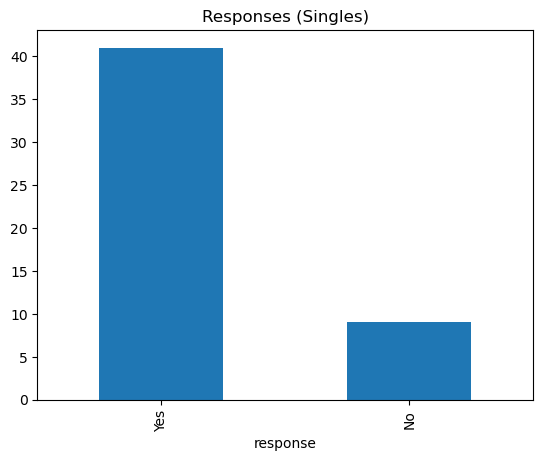

In [32]:
extract_and_analyze_results(singles, "Singles")


################# Analyzing results for Families... #################
Extraction raw result message: {'content': '{"response": "No", "justification": "While I appreciate the idea of luxury and relaxation, my current priorities are more focused on family-oriented vacations that offer adventure and cultural experiences."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response":"No","justification":"While I appreciate the idea of luxury and relaxation, my current situation and interests lean more towards family-oriented vacations that include adventure and exploration. I prefer destinations where my kids can play and we can all enjoy outdoor activities together."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, which aligns with what I look for in a vacation. I often seek quiet getaways wher

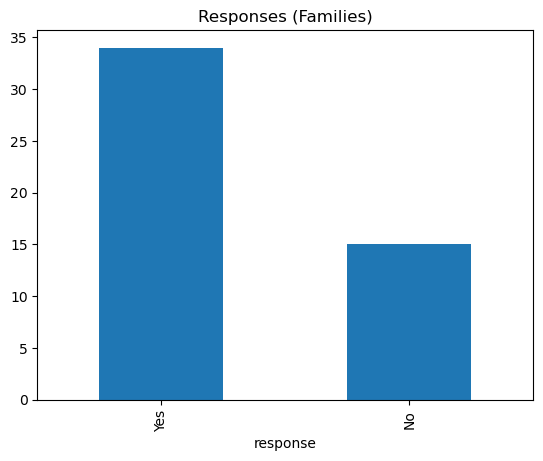

In [33]:
extract_and_analyze_results(families, "Families")

################# Analyzing results for Couples... #################
Extraction raw result message: {'content': '{"response":"Yes","justification":"I appreciate the focus on luxury and relaxation, which aligns with what I look for in a vacation. I often seek quiet getaways to recharge, and knowing that I can avoid fake reviews and bad experiences is a huge plus for me."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, which aligns with my desire for a calm getaway. I often find it challenging to navigate through reviews and find genuine experiences, so having a service that ensures quality would be very appealing."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, especially in beachfront and spa destination

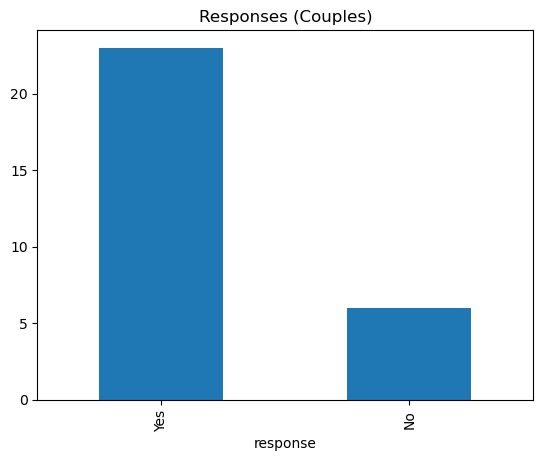

In [34]:
extract_and_analyze_results(couple, "Couples")

In [35]:
#extract_and_analyze_results(nongenuine_couples, "Non-genuine couples")

In [36]:
control.end()